### Impacts of a delayed and slow-paced vaccination on cases and deaths during the COVID-19 pandemic: a modelling study

Authors: Gustavo Barbosa Libotte$^\dagger$, Lucas dos Anjos$^\dagger$, Regina Célia Cerqueira de Almeida$^\dagger$, Sandra Mara Cardoso Malta$^\dagger$, and Roberto de Andrade Medronho$^\ddagger$

$^\dagger$National Laboratory for Scientific Computing, Petrópolis, Rio de Janeiro, Brazil\
$^\ddagger$Department of Epidemiology and Public Health, School of Medicine, Federal University of Rio de Janeiro, Rio de Janeiro, Brazil

#### Abstract:

Background: In Brazil, vaccination has always been cutting across party political and ideological lines, which have delayed its start and brought the whole process into disrepute. Such divergences put the immunisation of the population in the background and create additional hurdles beyond the pandemic, mistrust and scepticism over vaccines.

Methods: We conduct a mathematical modelling study to analyse the impacts of late vaccination and with slowly increasing coverage, as well as how harmful it would be if part of the population refused to get vaccinated or missed the second dose. We analyse data from confirmed cases, deaths caused by COVID-19, and vaccination in the state of Rio de Janeiro in the period between March 10, 2020, and October 27, 2021. The classical SIR model is extended to consider the effect of vaccination (efficacy, interval between doses, and vaccination rate) and data sets are regularised using Gaussian Process Regression. The model parameter distributions are estimated using Bayesian inference, aiming to obtain credible intervals in the simulations.

Findings: We estimate that if the start of vaccination had been 30 days earlier, combined with efforts to drive vaccination rates up, 31,657 (25,801–35,117) deaths could have been averted. Our results also indicate that the slow pace of vaccination and the low demand for the second dose could cause a resurgence of cases as early as 2022.

Interpretation: The government's inaction and lack of a strategic plan to fight the pandemic meant that vaccination started late, leading to thousands of deaths that could have been prevented. Even when reaching the expected vaccination coverage for the first dose, it is still challenging to increase adherence to the second dose and maintain a high vaccination rate to avoid new outbreaks.

Funding: Carlos Chagas Filho Foundation for Supporting Research in the State of Rio de Janeiro (FAPERJ) and Brazilian National Council for Scientific and Technological Development (CNPq).

----

### Dependencies

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import arviz as az
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import matplotlib.ticker as ticker
from datetime import date
from numba import jit
from scipy.integrate import solve_ivp
from datetime import date, datetime, timedelta
from scipy.optimize import curve_fit
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

from data_loading import LoadData
from proj_consts import ProjectConsts

### Graphics font properties

In [2]:
fontsize = 8

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": fontsize,
})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",
    "font.size": fontsize,
})

### Constants

In [3]:
gamma=0.06
rho=0.0514

var_names = [r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\sigma$"]
compartments = ["S", "I", "V1", "V2", "V3", "V4", "R", "D", "C", "W"]

percentile_cut = 2.5

pct_pop_to_vaccinate = 1.0
vaccination_rate = np.array([0.35, 0.4, 0.5]) / 100

# CoronaVac
eta1 = 0.504
tau1 = float(1/28)
v1 = 8_773_874

# Oxford-AstraZeneca
eta2 = 0.76
tau2 = float(1/84)
v2 = 9_877_055

# Pfizer
eta3 = 0.95
tau3 = float(1/84)
v3 = 9_377_610

# Janssen
eta4 = 0.66
tau4 = float(1/1)
v4 = 375_920

num_vaccines = (v1, v2, v3, v4,)

### Paths

In [4]:
INPUT_PATH = "../data"
OUTPUT_PATH = "../results"

### Read existing calibration realizations

In [5]:
par_realizations = pd.read_csv(f"{INPUT_PATH}/calibration_realizations.csv", usecols=var_names[:-1])
dict_par_realizations = az.convert_to_inference_data(par_realizations.to_dict(orient="list"))

### Functions for posterior calculation

In [6]:
def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calulating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

### Summary of calibrations

In [7]:
df_stats_summary = az.summary(
    data=dict_par_realizations,
    var_names=var_names[:-1],
    kind='stats',
    round_to=24,
    hdi_prob=0.95,
)
variable_mpvs = calculate_rv_posterior_mpv(
    pm_trace=par_realizations,
    variable_names=var_names[:-1],
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, variable_mpvs)
df_stats_summary.to_csv(f"{OUTPUT_PATH}/parameters_summary.csv")

Calulating MPV from KDE for $\beta_4$: 100%|██████████| 4/4 [00:00<00:00, 16.01it/s]


### Retrieving data
#### Full dataframe

In [8]:
location = "RJ"
target_population = ProjectConsts.RJ_STATE_POPULATION
mass_vaccinations_starts = date(2021,1,20)
today = date(2021,10,27)

df_brazil_state_data = LoadData.getBrazilDataFrame()
state_data = LoadData.getBrazilStateDataFrame(df_brazil_state_data, location)

#### Data before vaccination

In [9]:
state_data_before_vaccination = state_data[state_data["date"] < mass_vaccinations_starts]
days_before_vaccination = len(state_data_before_vaccination)

dead_individuals_before_vaccination = np.array(state_data_before_vaccination.deaths.values)
cummDeaths_individuals_before_vaccination = np.array(state_data_before_vaccination.cummDeaths.values)
infected_individuals_before_vaccination = np.array(state_data_before_vaccination.infected.values)
confirmed_cases_before_vaccination = np.array(state_data_before_vaccination.confirmed.values)
recovered_cases_before_vaccination = np.array(state_data_before_vaccination.recovered.values)

data_time_before_vaccination = state_data_before_vaccination.day.values.astype(np.float64)
data_time_before_vaccination = np.array(data_time_before_vaccination - data_time_before_vaccination[0])
dates_before_vaccination = state_data_before_vaccination.date.values
pd_dates_before_vaccination = pd.date_range(dates_before_vaccination[0], dates_before_vaccination[-1]).to_numpy()
dates_before_vaccination = [date.strftime("%d/%m/%y") for date in dates_before_vaccination]

data_before_vaccination = np.array([infected_individuals_before_vaccination,
                                    dead_individuals_before_vaccination,
                                    confirmed_cases_before_vaccination,
                                    cummDeaths_individuals_before_vaccination,
                                    recovered_cases_before_vaccination])

#### Data after vaccination begins

In [10]:
state_data_during_vaccination = state_data[state_data["date"] >= mass_vaccinations_starts]
state_data_during_vaccination = state_data_during_vaccination[state_data_during_vaccination["date"] <= today]

dead_individuals_during_vaccination = np.array(state_data_during_vaccination.deaths.values)
cummDeaths_individuals_during_vaccination = np.array(state_data_during_vaccination.cummDeaths.values)
infected_individuals_during_vaccination = np.array(state_data_during_vaccination.infected.values)
confirmed_cases_during_vaccination = np.array(state_data_during_vaccination.confirmed.values)
recovered_cases_during_vaccination = np.array(state_data_during_vaccination.recovered.values)
vaccinated = np.array(state_data_during_vaccination.vaccinated.values)
vaccinated_second = np.array(state_data_during_vaccination.vaccinated_second.values)

data_time_during_vaccination = state_data_during_vaccination.day.values.astype(np.float64)
data_time_during_vaccination = np.array(data_time_during_vaccination - data_time_during_vaccination[0] + data_time_before_vaccination[-1] + 1)
dates_during_vaccination = state_data_during_vaccination.date.values
pd_dates_during_vaccination = pd.date_range(dates_during_vaccination[0], dates_during_vaccination[-1]).to_numpy()
dates_during_vaccination = [date.strftime("%d/%m/%y") for date in dates_during_vaccination]

data_during_vaccination = np.array([infected_individuals_during_vaccination,
                                    dead_individuals_during_vaccination,
                                    confirmed_cases_during_vaccination,
                                    cummDeaths_individuals_during_vaccination,
                                    recovered_cases_during_vaccination,
                                    vaccinated,
                                    vaccinated_second])

#### Grouped data

In [11]:
data_time = np.concatenate((data_time_before_vaccination, data_time_during_vaccination))
data_dates = np.concatenate((dates_before_vaccination, dates_during_vaccination))

dead_individuals = np.concatenate((dead_individuals_before_vaccination, dead_individuals_during_vaccination))
infected_individuals = np.concatenate((infected_individuals_before_vaccination, infected_individuals_during_vaccination))

original_data = np.array([infected_individuals, dead_individuals])

### Loading regularized data

In [12]:
reg_data_calibration_dataframe = pd.read_csv(f"{INPUT_PATH}/regularized_data.csv", index_col=0)
reg_data_calibration = [reg_data_calibration_dataframe["infected"].values.astype(np.float64),
                        reg_data_calibration_dataframe["dead"].values.astype(np.float64)]
reg_data_stdev_calibration = [reg_data_calibration_dataframe["infected_min"].values.astype(np.float64),
                              reg_data_calibration_dataframe["infected_max"].values.astype(np.float64),
                              reg_data_calibration_dataframe["dead_min"].values.astype(np.float64),
                              reg_data_calibration_dataframe["dead_max"].values.astype(np.float64)]

### Plotting regularized data

<IPython.core.display.Javascript object>


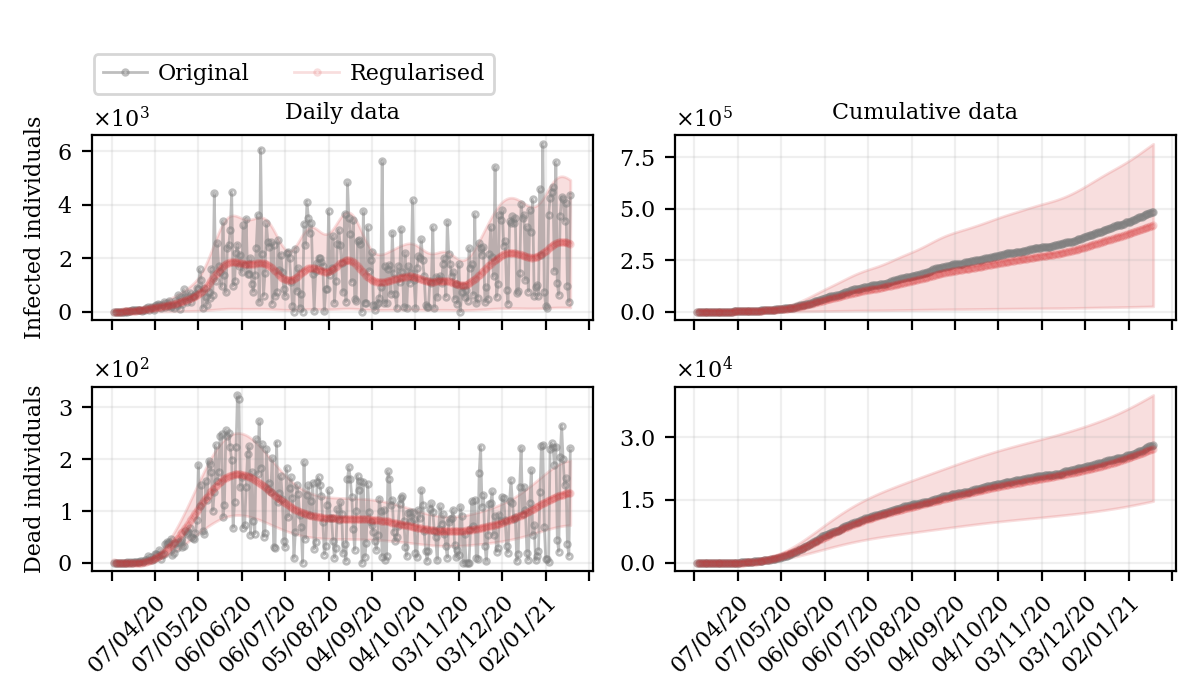

In [13]:
nrows = ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(6, 3.5))

for i in range(nrows):
    for j in range(ncols):
        if j == 0:
            if i == 0:
                ylabel = "Infected individuals"
            elif i == 1:
                ylabel = "Dead individuals"
            plot_original = data_before_vaccination[i]
            plot_reg = reg_data_calibration[i]
            (ax[i, j]).fill_between(dates_before_vaccination,
                                    reg_data_stdev_calibration[2 * i],
                                    reg_data_stdev_calibration[2 * i + 1],
                                    color="C3",
                                    alpha=0.15)
            (ax[i, j]).set_ylabel(ylabel)
        elif j == 1:
            plot_original = np.cumsum(data_before_vaccination[i])
            plot_reg = np.cumsum(reg_data_calibration[i])
            (ax[i, j]).fill_between(dates_before_vaccination,
                                    np.cumsum(reg_data_stdev_calibration[2 * i]),
                                    np.cumsum(reg_data_stdev_calibration[2 * i + 1]),
                                    color="C3",
                                    alpha=0.15)

        (ax[i, j]).grid(alpha=0.2)

        (ax[i, j]).plot(
            dates_before_vaccination,
            plot_original,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color="C7",
            fillstyle="none",
            markeredgecolor="C7",
            label="Original",
            alpha=0.5,
        )

        (ax[i, j]).plot(
            dates_before_vaccination,
            plot_reg,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color="C3",
            fillstyle="none",
            markeredgecolor="C3",
            label="Regularised",
            alpha=0.15,
        )
        
        if i == 0 and j == 0:
            (ax[i, j]).legend(loc="upper right", fontsize=fontsize, ncol=2, handletextpad=0.5, bbox_to_anchor=(0.825,1.5))
            (ax[i, j]).set_title("Daily data", fontsize=fontsize)
        if i == 0 and j == 1:
            (ax[i, j]).set_title("Cumulative data", fontsize=fontsize)

        (ax[i, j]).xaxis.set_major_locator(mdates.DayLocator(interval=30))
        plt.setp((ax[i, j]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        (ax[i, j]).yaxis.major.formatter._useMathText = True
        (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "data_regularization" + ".pdf")

### Defining expression for $\mathcal{R}(t)$

We employ the next-generation matrix method to derive the effective reproduction number expression, which is given by

\begin{equation} \label{eq:Rt}
    \mathcal{R} \left( t \right) = \dfrac{\beta \left( t \right) S \left( t \right)}{N \left( \gamma + \rho + \sum\limits_{i = 1}^{n} \nu_{i} \right)} \; .
\end{equation}

For detailed derivation, refer to Supplementary Notes 1.

In [14]:
def sim_Rt(time_span, days_before_vacc, scenario, days, population, gamma, rho, nu1, nu2, nu3, nu4, S, beta1, beta2, beta3, beta4):
    beta = beta1 * np.exp(-beta2 * time_span) + beta3 * np.exp(beta4 * time_span)
    nu_sum = nu1 + nu2 + nu3 + nu4
    
    if scenario == "delayed":
        days_scenario = days_before_vacc + days
    elif scenario == "advanced":
        days_scenario = days_before_vacc - days
    
    Rt = np.zeros_like(time_span)
    for i in range(len(time_span)):
        if i <= days_scenario:
            Rt[i] = (beta[i] * S[i]) / (population * (gamma + rho))
        else:
            Rt[i] = (beta[i] * S[i]) / (population * (gamma + rho + nu_sum))
    return Rt

### Defining the model

The incidence of new cases is given by $ \beta \left( t \right) S \left( t \right) I \left( t \right) / N $, where $ N $ is the population size. Both susceptible and infected individuals are vaccinated at a rate proportional to $ \nu $. Once infected, individuals are moved to the removed class at a rate proportional to $ \gamma $, whereas the gain in the dead class is at a rate proportional to $ \rho $. Vaccinated individuals can either be moved into the removed class or become susceptible again, respecting the interval between doses, $ 1/\tau $, when applicable. In the first case, immunised individuals are moved into the removed class proportionally to $ \eta $, the overall vaccine efficacy. In the second case, the susceptible class is fed back proportionally to $ \left( 1 - \eta \right) $. The portion of individuals who do not receive the second dose is equal to $ \alpha $. In this case, an overall impaired efficacy is assumed, given by $ \bar{\eta} $. In general, the model admits $ n $ classes of vaccinated, depending on the types of vaccines used.

\begin{equation} \label{eq:model}
    \begin{aligned}
        &\dfrac{\mathrm{d} S \left( t \right)}{\mathrm{d} t} = -\beta \left( t \right) \dfrac{S\left( t \right) I\left( t \right)}{N} - \sum\limits_{i = 1}^{n} \Big( \nu_{i} S\left( t \right) - \tau_{i} \left( \left( 1 - \eta_{i} \right) \left( 1 - \alpha \right) + \left( 1 - \bar{\eta}_{i} \right) \alpha \right) V_{i}\left( t \right) \Big)\\
        &\dfrac{\mathrm{d} I \left( t \right)}{\mathrm{d} t} = \beta \left( t \right) \dfrac{S\left( t \right) I\left( t \right)}{N} - \left( \gamma + \rho + \sum\limits_{i = 1}^{n} \nu_{i} \right) I \left( t \right)\\
        &\dfrac{\mathrm{d} V_{i} \left( t \right)}{\mathrm{d} t} = \nu_{i} \left( S \left( t \right) + I \left( t \right) \right) - \tau_{i} V_{i}\\
        &\dfrac{\mathrm{d} R \left( t \right)}{\mathrm{d} t} = \gamma I \left( t \right) + \sum\limits_{i = 1}^{n} \tau_{i} \left( \eta_{i} \left( 1 - \alpha \right) + \bar{\eta}_{i} \alpha \right) V_{i}\left( t \right)\\
        &\dfrac{\mathrm{d} D \left( t \right)}{\mathrm{d} t} = \rho I \left( t \right)
    \end{aligned}
\end{equation}

In [15]:
def sivrd_model(
    t,
    X,
    beta1,
    beta2,
    beta3,
    beta4,
    nu1,
    nu2,
    nu3,
    nu4,
    tau1,
    tau2,
    tau3,
    tau4,
    eta1,
    eta2,
    eta3,
    eta4,
    N,
    days_before_vacc,
    target_pop,
    scenario,
    scenario_arg,
    scenario_arg2,
):
    beta = beta1 * np.exp(-beta2 * t) + beta3 * np.exp(beta4 * t)
    gamma=0.06
    rho=0.0514
    
    S, I, V1, V2, V3, V4, R, D, C, W = X
    
    epsilon = 0
    eta1c = eta2c = eta3c = eta4c = 0
    if scenario is None and scenario_arg is None:
        if t <= days_before_vacc:
            nu1 = nu2 = nu3 = nu4 = 0
            tau1 = tau2 = tau3 = tau4 = 0
            eta1 = eta2 = eta3 = eta4 = 0
    else:
        if scenario == "advanced":
            if t <= (days_before_vacc - scenario_arg):
                nu1 = nu2 = nu3 = nu4 = 0
                tau1 = tau2 = tau3 = tau4 = 0
                eta1 = eta2 = eta3 = eta4 = 0
        elif scenario == "delayed":
            if t <= (days_before_vacc + scenario_arg):
                nu1 = nu2 = nu3 = nu4 = 0
                tau1 = tau2 = tau3 = tau4 = 0
                eta1 = eta2 = eta3 = eta4 = 0
        elif scenario == "limited":
            if t <= days_before_vacc or W >= (scenario_arg * target_pop):
                nu1 = nu2 = nu3 = nu4 = 0
                tau1 = tau2 = tau3 = tau4 = 0
                eta1 = eta2 = eta3 = eta4 = 0
        elif scenario == "second":
            if t <= days_before_vacc:
                nu1 = nu2 = nu3 = nu4 = 0
                tau1 = tau2 = tau3 = tau4 = 0
                eta1 = eta2 = eta3 = eta4 = 0
                
            epsilon = scenario_arg
            eta1c = scenario_arg2 * eta1
            eta2c = scenario_arg2 * eta2
            eta3c = scenario_arg2 * eta3
            eta4c = scenario_arg2 * eta4
    
    S_prime = -beta / N * S * I - (nu1 + nu2 + nu3 + nu4) * S + tau1 * ((1 - eta1) * (1 - epsilon) + (1 - eta1c) * epsilon) * V1 + tau2 * ((1 - eta2) * (1 - epsilon) + (1 - eta2c) * epsilon) * V2 + tau3 * ((1 - eta3) * (1 - epsilon) + (1 - eta3c) * epsilon) * V3 + tau4 * ((1 - eta4) * (1 - epsilon) + (1 - eta4c) * epsilon) * V4
    I_prime = beta / N * S * I - (gamma + nu1 + nu2 + nu3 + nu4 + rho) * I
    V1_prime = nu1 * (S + I) - tau1 * V1
    V2_prime = nu2 * (S + I) - tau2 * V2
    V3_prime = nu3 * (S + I) - tau3 * V3
    V4_prime = nu4 * (S + I) - tau4 * V4
    R_prime = gamma * I + tau1 * (eta1 * (1 - epsilon) + eta1c * epsilon) * V1 + tau2 * (eta2 * (1 - epsilon) + eta2c * epsilon) * V2 + tau3 * (eta3 * (1 - epsilon) + eta3c * epsilon) * V3 + tau4 * (eta4 * (1 - epsilon) + eta4c * epsilon) * V4
    D_prime = rho * I
    C_prime = beta / N * S * I
    W_prime = (nu1 + nu2 + nu3 + nu4) * (S + I)
    return S_prime, I_prime, V1_prime, V2_prime, V3_prime, V4_prime, R_prime, D_prime, C_prime, W_prime

### Defining the ODE solver

In [16]:
def sivrd_ode_solver(
    y0,
    t_span,
    t_eval,
    N,
    days_before_vacc,
    scenario,
    scenario_arg,
    scenario_arg2,
    target_pop,
    beta1,
    beta2,
    beta3,
    beta4,
    nu1=0,
    nu2=0,
    nu3=0,
    nu4=0,
    tau1=0,
    tau2=0,
    tau3=0,
    tau4=0,
    eta1=0,
    eta2=0,
    eta3=0,
    eta4=0,
):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sivrd_model(
            t,
            y,
            beta1=beta1,
            beta2=beta2,
            beta3=beta3,
            beta4=beta4,
            nu1=nu1,
            nu2=nu2,
            nu3=nu3,
            nu4=nu4,
            tau1=tau1,
            tau2=tau2,
            tau3=tau3,
            tau4=tau4,
            eta1=eta1,
            eta2=eta2,
            eta3=eta3,
            eta4=eta4,
            N=N,
            days_before_vacc=days_before_vacc,
            target_pop=target_pop,
            scenario=scenario,
            scenario_arg=scenario_arg,
            scenario_arg2=scenario_arg2,
        ),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method="RK45",
    )

    return solution_ODE

### Function for model simulation

In [17]:
def simulate_model(data_time, y0, pars, target_population, days_before_vacc, scenario=None, scenario_arg=None, scenario_arg2=None):
    S0 = target_population - (y0[0] + y0[1] + y0[2] + y0[3] + y0[4] + y0[5] + y0[6])
    y0_sol = S0, y0[0], y0[1], y0[2], y0[3], y0[4], y0[5], y0[6], y0[7], y0[8]

    t0 = float(data_time.min())
    tf = float(data_time.max())

    solution_ODE = sivrd_ode_solver(
        y0_sol, (t0, tf), data_time, target_population, days_before_vacc, scenario, scenario_arg, scenario_arg2, target_population, *pars
    )

    t_solution_ODE, y_solution_ODE = (
        solution_ODE.t,
        solution_ODE.y,
    )
        
    return y_solution_ODE

### Setting up initial conditions

In [18]:
I0, V10, V20, V30, V40, R0, D0, C0, W0 = (reg_data_calibration[0][0] + 1, # I0
                                          0.0,                            # V10
                                          0.0,                            # V20
                                          0.0,                            # V30
                                          0.0,                            # V40
                                          0.0,                            # R0
                                          reg_data_calibration[1][0],     # D0
                                          0.0,                            # C0
                                          0.0)                            # W0
y0_sivrd = np.array([I0, V10, V20, V30, V40, R0, D0, C0, W0], dtype=np.float64)

### Function for simulating the model for vaccination

In [19]:
def simulate_vaccination_scenarios(vacc_rate, pct_pop_vacc, data_time_before_vacc, dates_before_vacc, par_realiz,
                                   var_names, y0, total_pop, days_before_vacc, mpvs, comps, perc_cut, sim_model,
                                   num_vaccines, scenario=None, scenario_arg=None, scenario_arg2=None,
                                   days_extend_sim=None):
    model_sim_vacc_rate = dict()

    for nu in vacc_rate:

        S_realization = list()
        I_realization = list()
        V1_realization = list()
        V2_realization = list()
        V3_realization = list()
        V4_realization = list()
        R_realization = list()
        D_realization = list()
        C_realization = list()
        W_realization = list()

        model_sim_vacc_rate[nu] = dict()
        
        sum_vaccines = sum(list(num_vaccines))
        nu1, nu2, nu3, nu4 = tuple((num_vacc / sum_vaccines) * nu for num_vacc in num_vaccines)
        days_to_vaccinate = (pct_pop_vacc // nu)
        days_to_vaccinate = days_to_vaccinate + (2 * (days_to_vaccinate // 7))
        if days_extend_sim != None:
            days_to_vaccinate = days_to_vaccinate + days_extend_sim

        t0 = int(data_time_before_vacc[0])
        tf = int(data_time_before_vacc[-1] + days_to_vaccinate)
        time_span_simulation = np.linspace(start=t0, stop=tf, num=tf - t0 + 1, endpoint=True)

        array_dates = [datetime.strftime((datetime.strptime(dates_before_vacc[0], "%d/%m/%y")
                                        + timedelta(days = day)).date(), "%d/%m/%y") for day in range(tf + 1)]

        for i in trange(len(par_realiz.index)):
            beta_realization = list()
            for var_name in var_names[:-1]:
                beta_realization += [par_realiz[var_name].values[i]]

            sim_parameters = [*beta_realization,
                              nu1, nu2, nu3, nu4,
                              tau1, tau2, tau3, tau4,
                              eta1, eta2, eta3, eta4]

            S_sim, I_sim, V1_sim, V2_sim, V3_sim, V4_sim, R_sim, D_sim, C_sim, W_sim = sim_model(time_span_simulation,
                                                                                                 y0,
                                                                                                 sim_parameters,
                                                                                                 total_pop,
                                                                                                 days_before_vacc,
                                                                                                 scenario,
                                                                                                 scenario_arg,
                                                                                                 scenario_arg2)

            S_realization += [S_sim]
            I_realization += [I_sim]
            V1_realization += [V1_sim]
            V2_realization += [V2_sim]
            V3_realization += [V3_sim]
            V4_realization += [V4_sim]
            R_realization += [R_sim]
            D_realization += [np.diff(D_sim)]
            C_realization += [C_sim]
            W_realization += [W_sim]


        model_realizations = [S_realization,
                              I_realization,
                              V1_realization,
                              V2_realization,
                              V3_realization,
                              V4_realization,
                              R_realization,
                              D_realization,
                              C_realization,
                              W_realization]

        sim_parameters_map = [*list(mpvs.values()),
                              nu1, nu2, nu3, nu4,
                              tau1, tau2, tau3, tau4,
                              eta1, eta2, eta3, eta4]

        model_sim_map = sim_model(time_span_simulation,
                                  y0,
                                  sim_parameters_map,
                                  total_pop,
                                  days_before_vacc,
                                  scenario,
                                  scenario_arg,
                                  scenario_arg2)

        for k, compartment in enumerate(comps):
            model_sim_vacc_rate[nu][compartment] = dict()

            model_sim_vacc_rate[nu][compartment]["min"] = np.percentile(model_realizations[k],
                                                                        perc_cut,
                                                                        axis=0)
            model_sim_vacc_rate[nu][compartment]["max"] = np.percentile(model_realizations[k],
                                                                        100 - perc_cut,
                                                                        axis=0)
            if compartment == "D":
                model_sim_vacc_rate[nu][compartment]["map"] = np.diff(model_sim_map[k])
            else:
                model_sim_vacc_rate[nu][compartment]["map"] = model_sim_map[k]

        model_sim_vacc_rate[nu]["dates"] = array_dates
        
    return model_sim_vacc_rate

### Simulating the model for different vaccination rates

In [20]:
model_sim_vacc_rate = simulate_vaccination_scenarios(vaccination_rate, pct_pop_to_vaccinate,
                                                     data_time_before_vaccination, dates_before_vaccination,
                                                     par_realizations, var_names, y0_sivrd, target_population,
                                                     days_before_vaccination, variable_mpvs, compartments,
                                                     percentile_cut, simulate_model, num_vaccines, None, None, None)

100%|██████████| 2000/2000 [00:55<00:00, 36.32it/s]


### Simulating the model for vaccination considering limited number of doses available

In [21]:
model_sim_limited_doses = simulate_vaccination_scenarios(vaccination_rate, pct_pop_to_vaccinate,
                                                         data_time_before_vaccination, dates_before_vaccination,
                                                         par_realizations, var_names, y0_sivrd, target_population,
                                                         days_before_vaccination, variable_mpvs, compartments,
                                                         percentile_cut, simulate_model, num_vaccines,
                                                         "limited", 0.725, None, 120)

100%|██████████| 2000/2000 [00:54<00:00, 36.63it/s]


### Simulating the model for vaccination considering a delay of 30 days on the start date

In [22]:
model_sim_delayed = simulate_vaccination_scenarios(vaccination_rate, pct_pop_to_vaccinate,
                                                   data_time_before_vaccination, dates_before_vaccination,
                                                   par_realizations, var_names, y0_sivrd, target_population,
                                                   days_before_vaccination, variable_mpvs, compartments,
                                                   percentile_cut, simulate_model, num_vaccines, "delayed", 30, None)

100%|██████████| 2000/2000 [00:49<00:00, 40.23it/s]


### Simulating the model for vaccination considering an advance of 30 days on the start date

In [23]:
model_sim_advanced = simulate_vaccination_scenarios(vaccination_rate, pct_pop_to_vaccinate,
                                                    data_time_before_vaccination, dates_before_vaccination,
                                                    par_realizations, var_names, y0_sivrd, target_population,
                                                    days_before_vaccination, variable_mpvs, compartments,
                                                    percentile_cut, simulate_model, num_vaccines, "advanced", 30, None)

100%|██████████| 2000/2000 [00:59<00:00, 33.54it/s]


### Simulations for various advances/delays on the start date of vaccination

In [24]:
scenario_analysis = ["delayed", "advanced"]
days_scenario_analysis = [10, 20, 30]

model_sim_scenario_analysis = dict()
for scenario in scenario_analysis:
    model_sim_scenario_analysis[scenario] = dict()
    for days in days_scenario_analysis:
        model_sim_scenario_analysis[scenario][days] = simulate_vaccination_scenarios(vaccination_rate,
                                                                                     pct_pop_to_vaccinate,
                                                                                     data_time_before_vaccination,
                                                                                     dates_before_vaccination,
                                                                                     par_realizations,
                                                                                     var_names,
                                                                                     y0_sivrd,
                                                                                     target_population,
                                                                                     days_before_vaccination,
                                                                                     variable_mpvs,
                                                                                     compartments,
                                                                                     percentile_cut,
                                                                                     simulate_model,
                                                                                     num_vaccines,
                                                                                     scenario,
                                                                                     days,
                                                                                     None)

100%|██████████| 2000/2000 [01:01<00:00, 32.60it/s]


In [25]:
model_sim_scenario_analysis["ontime"] = dict()
model_sim_scenario_analysis["ontime"][0] = model_sim_vacc_rate

### Simulating scenarios considering a limited number of people taking the second dose

In [26]:
epsilon_analysis = [0, 0.1, 0.2]
protection_analysis = [0.25, 0.5, 0.75]

model_sim_second_dose = dict()
for epsilon in epsilon_analysis:
    model_sim_second_dose[epsilon] = dict()
    for protection in protection_analysis:
        model_sim_second_dose[epsilon][protection] = simulate_vaccination_scenarios(vaccination_rate,
                                                                                    pct_pop_to_vaccinate,
                                                                                    data_time_before_vaccination,
                                                                                    dates_before_vaccination,
                                                                                    par_realizations,
                                                                                    var_names,
                                                                                    y0_sivrd,
                                                                                    target_population,
                                                                                    days_before_vaccination,
                                                                                    variable_mpvs,
                                                                                    compartments,
                                                                                    percentile_cut,
                                                                                    simulate_model,
                                                                                    num_vaccines,
                                                                                    "second",
                                                                                    epsilon,
                                                                                    protection)

100%|██████████| 2000/2000 [00:55<00:00, 35.92it/s]


---
# Plotting main results
## How effective would a faster vaccination process be in mitigating the epidemic?
### Function to plot map with doses distribution

In [71]:
def plot_map_doses(ax):
    INFOS_UFS = gpd.read_file(f"{INPUT_PATH}/bcim_2016_21_11_2018.gpkg", layer="lim_unidade_federacao_a")
    
    states_ufs_names = dict(zip(INFOS_UFS["sigla"].values, INFOS_UFS["nome"].values))

    states_doses = pd.read_excel(f"{INPUT_PATH}/6206a11b-adf7-4bc2-82c6-e18e2fbf68d8.xlsx")
    states_ufs = states_doses.UF.unique()
    states_ufs = np.delete(states_ufs, np.where(states_ufs == "-"))
    
    states_population = pd.read_excel(f"{INPUT_PATH}/68aa177f0dceed79ad427cd0800169c8.xlsx")
    states_population = dict(zip(states_population["UF [-]"].values,
                                      states_population["População estimada - pessoas [2020]"].values))

    country_doses = 0
    number_doses_states = list()
    dict_states_doses = dict()
    for uf in states_ufs:
        country_doses = country_doses + np.sum(states_doses[states_doses.UF == uf].DOSES.values)
        number_doses_states += [np.sum(states_doses[states_doses.UF == uf].DOSES.values)
                                / (states_population.get(states_ufs_names.get(uf)) / 100_000)]
        dict_states_doses[uf] = int(number_doses_states[-1])
    dict_states_doses = dict(sorted(dict_states_doses.items(), key=lambda item: item[1]))
    print(dict_states_doses)
    country_doses_100k = country_doses / (214_577_957 / 100_000)
    print(f"BR: {country_doses_100k}")

    infos_states_doses = INFOS_UFS.merge(pd.DataFrame(data={"sigla": states_ufs,
                                                            "doses": number_doses_states}),
                                         on="sigla", how="left")
    
    ax.axis("off")
    
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${}$'.format(a)

    ax2 = infos_states_doses.plot(column="doses",
                            cmap="Reds",
                            edgecolor="black",
                            linewidth=0.5,
                            ax=ax,
                            legend=True,
                            clip_on=True,
                            legend_kwds={"label": "Doses per 100,000\ninhabitants " + r"$\left(\times10^5\right)$" + "\nuntil Oct. 27, 2021",
                                         "location": "left",
                                         "shrink": 0.5,
                                         "anchor": (-0.9, 0.55),
                                         "aspect": 10,
                                         "format": ticker.FuncFormatter(fmt)})
    
    ax.set_position([0.03, 0.37, 0.39230313465473254, 0.88])

    state_centroid = INFOS_UFS[INFOS_UFS.sigla == "RJ"].geometry.centroid

    ax.annotate(None,
                xy=(float(state_centroid.x)+1, float(state_centroid.y)-1), xycoords='data',
                xytext=(float(state_centroid.x)+12, float(state_centroid.y)+2), textcoords='data',
                arrowprops=dict(
                    arrowstyle="fancy", connectionstyle="arc3,rad=-0.5", fc="#262626", ec="#262626",
                    lw=2,
                ))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="50%", pad=-0.5)
    
    num_doses = states_doses[states_doses.UF == "RJ"].DOSES.values
    pct_doses = num_doses / sum(num_doses)

    def func_pct(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%".format(pct, absolute)

    my_pie, texts, pct_txts = cax.pie(pct_doses, autopct=lambda pct: func_pct(pct, pct_doses),
                                      pctdistance=0.75, startangle=0, center=(-15,-15), textprops={'color': 'black', 'fontweight': 'extra bold'},
                                      colors=("C0", "C1", "C8", "C2"))
    plt.setp(my_pie, width=0.5, edgecolor="white")  

    for wedge in range(len(my_pie)):
        my_pie[wedge].set_alpha(0.6)

    leg1 = cax.legend(my_pie[:2], ["Sinovac", "Oxford-AstraZeneca"], loc="upper center", ncol=1, bbox_to_anchor=(0.45, 1.25), fontsize=fontsize, labelspacing=0.2)
    leg2 = cax.legend(my_pie[2:], ["Janssen", "Pfizer-BioNTech"], loc="upper center", ncol=1, bbox_to_anchor=(0.5, 0.05), fontsize=fontsize, labelspacing=0.2)
    cax.add_artist(leg1)
    cax.add_artist(leg2)

### Function to plot histogram with vaccination rates

In [72]:
def plot_hist_vacc_rates(ax, pop_size, data_vacc, data_vacc_second, dates_during_vacc):
    pop_vaccinated = data_vacc / pop_size
    daily_pop_vaccinated = np.diff(pop_vaccinated)

    idx_vaccinated_second = np.where(data_vacc_second > 0)
    dates_during_vaccination_second = np.array(dates_during_vacc)[idx_vaccinated_second]
    pop_vaccinated_second = data_vacc_second[idx_vaccinated_second] / pop_size
    daily_pop_vaccinated_second = np.diff(pop_vaccinated_second)

    pop_vaccinated_first_second = (data_vacc[idx_vaccinated_second] +
                               data_vacc_second[idx_vaccinated_second])  / pop_size
    daily_pop_vaccinated_first_second = np.diff(pop_vaccinated_first_second)

    ax.hist((daily_pop_vaccinated[daily_pop_vaccinated > 0]) * 100, bins=40, label="First shot", color="C1", alpha=0.15)
    ax.hist((daily_pop_vaccinated_second[daily_pop_vaccinated_second > 0]) * 100, bins=20, label="Second shot", color="C2", alpha=0.15)

    ax.set_xlim([0, 1])
    ax.set_yticklabels([])
    ax.set_xlabel("Vaccination rate (% of the population per day)")
    ax.set_ylabel("Frequency")
    ax.legend()

### Function to plot vaccination prediction

In [73]:
def plot_vacc_pred(ax, pop_size, data_vacc, data_time_during_vacc, dates_during_vacc, data_vacc_second):
    fun_fit_vacc = lambda t, a, b, c: a * t**2 - b * t + c

    pop_vaccinated = data_vacc / pop_size
    popt, pcov = curve_fit(fun_fit_vacc, data_time_during_vacc, pop_vaccinated * 100)
    sigma_abc = np.sqrt(np.diagonal(pcov))

    bound_upper_during_vaccination = fun_fit_vacc(data_time_during_vacc, *(popt + sigma_abc))
    bound_lower_during_vaccination = fun_fit_vacc(data_time_during_vacc, *(popt - sigma_abc))
    bound_lower_during_vaccination[np.where(bound_lower_during_vaccination < 0)] = 0

    num_days_predict_vacc = 170
    data_time_predict_vaccination = np.linspace(data_time_during_vacc[-1],
                                                data_time_during_vacc[-1] + num_days_predict_vacc,
                                                num_days_predict_vacc).astype(int)

    start_date_predict_vacc = datetime.strptime(dates_during_vacc[-1], "%d/%m/%y")
    end_date_predict_vacc = datetime.strptime(dates_during_vacc[-1], "%d/%m/%y") + timedelta(days = num_days_predict_vacc)
    dates_predict_vaccination = [start_date_predict_vacc + timedelta(days = x) for x in range(0,
                                 (end_date_predict_vacc-start_date_predict_vacc).days)]

    for i, date in enumerate(dates_predict_vaccination):
        dates_predict_vaccination[i] = date.strftime("%d/%m/%y")

    bound_upper_predict_vacc = fun_fit_vacc(data_time_predict_vaccination, *(popt + sigma_abc))
    bound_lower_predict_vacc = fun_fit_vacc(data_time_predict_vaccination, *(popt - sigma_abc))
    bound_lower_predict_vacc[np.where(bound_lower_predict_vacc < 0)] = 0
    
    idx_vaccinated_second = np.where(data_vacc_second > 0)
    dates_during_vaccination_second = np.array(dates_during_vacc)[idx_vaccinated_second]
    pop_vaccinated_second = data_vacc_second[idx_vaccinated_second] / pop_size
    data_time_during_vaccination_second = np.array(data_time_during_vacc)[idx_vaccinated_second]

    popt_second, pcov_second = curve_fit(fun_fit_vacc, data_time_during_vaccination_second, pop_vaccinated_second * 100)
    sigma_abc_second = np.sqrt(np.diagonal(pcov_second))

    bound_upper_during_vaccination_second = fun_fit_vacc(data_time_during_vaccination_second, *(popt_second + sigma_abc_second))
    bound_lower_during_vaccination_second = fun_fit_vacc(data_time_during_vaccination_second, *(popt_second - sigma_abc_second))
    bound_lower_during_vaccination_second[np.where(bound_lower_during_vaccination_second < 0)] = 0

    num_days_predict_vacc_second = 240
    data_time_predict_vaccination_second = np.linspace(data_time_during_vaccination_second[-1],
                                                data_time_during_vaccination_second[-1] + num_days_predict_vacc_second,
                                                num_days_predict_vacc_second).astype(int)

    start_date_predict_vacc_second = datetime.strptime(dates_during_vaccination_second[-1], "%d/%m/%y")
    end_date_predict_vacc_second = datetime.strptime(dates_during_vaccination_second[-1], "%d/%m/%y") + timedelta(days = num_days_predict_vacc_second)
    dates_predict_vaccination_second = [start_date_predict_vacc_second + timedelta(days = x) for x in range(0,
                                 (end_date_predict_vacc_second-start_date_predict_vacc_second).days)]

    for i, date in enumerate(dates_predict_vaccination_second):
        dates_predict_vaccination_second[i] = date.strftime("%d/%m/%y")

    bound_upper_predict_vacc_second = fun_fit_vacc(data_time_predict_vaccination_second, *(popt_second + sigma_abc_second))
    bound_lower_predict_vacc_second = fun_fit_vacc(data_time_predict_vaccination_second, *(popt_second - sigma_abc_second))
    bound_lower_predict_vacc_second[np.where(bound_lower_predict_vacc_second < 0)] = 0

    ### First shot

    ax.plot(
        dates_during_vacc,
        pop_vaccinated * 100,
        label="First shot",
        marker="o",
        linestyle="",
        markersize=3,
        linewidth=0,
        color="C1",
        alpha=0.5,
    )
    
    print(f"First shot, {dates_during_vacc[-1]}: {(pop_vaccinated * 100)[-1]}%")

    ax.plot(
        dates_during_vacc,
        fun_fit_vacc(data_time_during_vaccination, *popt),
        linestyle="-",
        markersize=0,
        linewidth=2,
        color="C0",
        alpha=0.5,

    )

    ax.fill_between(dates_during_vacc,
                     bound_lower_during_vaccination,
                     bound_upper_during_vaccination,
                     color = 'black',
                     alpha = 0.2,
                     edgecolor=None,
    )

    ax.plot(
        dates_predict_vaccination,
        fun_fit_vacc(data_time_predict_vaccination, *popt),
        linestyle="--",
        markersize=0,
        linewidth=2,
        color="C0",
        alpha=0.5,

    )

    ax.fill_between(dates_predict_vaccination,
                     bound_lower_predict_vacc,
                     bound_upper_predict_vacc,
                     color = 'black',
                     alpha = 0.2,
                     edgecolor=None,
    )


    ### Second shot

    ax.plot(
        dates_during_vaccination_second,
        pop_vaccinated_second * 100,
        label="Second shot",
        marker="o",
        linestyle="",
        markersize=3,
        linewidth=0,
        color="C3",
        alpha=0.25,
    )
    
    print(f"Second shot, {dates_during_vaccination_second[-1]}: {(pop_vaccinated_second * 100)[-1]}%")

    ax.plot(
        dates_during_vaccination_second,
        fun_fit_vacc(data_time_during_vaccination_second, *popt_second),
        linestyle="-",
        markersize=0,
        linewidth=2,
        color="C0",
        alpha=0.5,

    )

    ax.fill_between(dates_during_vaccination_second,
                     bound_lower_during_vaccination_second,
                     bound_upper_during_vaccination_second,
                     color = 'black',
                     alpha = 0.2,
                     edgecolor=None,
    )

    ax.plot(
        dates_predict_vaccination_second,
        fun_fit_vacc(data_time_predict_vaccination_second, *popt_second),
        linestyle="--",
        markersize=0,
        linewidth=2,
        color="C0",
        alpha=0.5,

    )

    ax.fill_between(dates_predict_vaccination_second,
                     bound_lower_predict_vacc_second,
                     bound_upper_predict_vacc_second,
                     color = 'black',
                     alpha = 0.2,
                     edgecolor=None,
    )

    ###

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_ylabel("Vaccinated\npopulation (%)")
    ax.grid(alpha=0.2)
    
    ax.set_xlim([-26, 400])

    ax.set_ylim([ax.get_ylim()[0], 80])

    ax.legend(loc="upper left")

### Function to plot $\beta\left(t\right)$

In [74]:
def plot_beta_t(ax, par_realiz, var_names, percentile_cut, variable_mpvs, dates_before_vacc,
               data_time_before_vacc, infected_before_vacc):
    beta_fun = lambda t, beta1, beta2, beta3, beta4: beta1 * np.exp(-beta2 * t) + beta3 * np.exp(beta4 * t)
    
    values_beta_realization = list()
    for i in range(len(par_realiz.index)):
        beta_realization = list()
        for var_name in var_names[:-1]:
            beta_realization += [par_realiz[var_name].values[i]]
        values_beta_realization += [beta_fun(data_time_before_vacc, *beta_realization)]

    min_values_beta_fun = np.percentile(values_beta_realization, percentile_cut, axis=0)
    max_values_beta_fun = np.percentile(values_beta_realization, 100 - percentile_cut, axis=0)
    map_values_beta_fun = beta_fun(data_time_before_vacc, *list(variable_mpvs.values()))

    lns1 = ax.plot(dates_before_vacc,
            map_values_beta_fun,
                  label=r"$\beta\left(t\right)$")

    ax.fill_between(data_time_before_vacc,
                   min_values_beta_fun,
                   max_values_beta_fun,
                   alpha=0.2)

    ax2 = ax.twinx()

    lns2 = ax2.plot(dates_before_vacc,
             infected_before_vacc,
             marker="o", markersize=2, color="C7", alpha=0.25, linewidth=0.5, label="Infected individuals")

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=25))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax2.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
    ax2.yaxis.major.formatter._useMathText = True
    ax2.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.set_ylabel(r"$\beta(t)$")
    ax2.set_ylabel(r"$I(t)$")
    ax.grid(alpha=0.2)
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    leg = ax2.legend(lns, labs, loc='upper right', ncol=2)
    leg.get_frame().set_facecolor((1, 1, 1, 1))

### Function to plot parameter posteriors

In [75]:
def plot_beta_post(axs, dict_par_realiz, var_names, fontsize):
    for k, ax in enumerate(axs):
        ax_post = az.plot_posterior(
            dict_par_realiz, 
            var_names=var_names[k], 
            kind="hist", 
            round_to=3,
            hdi_prob="hide",
            bins=15,
            point_estimate=None,
            textsize=fontsize,
            ax=ax,
            facecolor="C0",
            rwidth=0.85,
        )

        ax.set_title("")
        ax.set_xlabel(var_names[k])

        ax.xaxis.major.formatter._useMathText = True
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))

### Function to plot simulations

In [76]:
def plot_vaccination_scenarios_nu(axs, vacc_rate, model_sim_vacc_rate, dates_before_vacc, data_before_vacc):
    ax_labels = ["I", "C", "R", "D", "Dc", "W"]
    
    for nu in vacc_rate:
        print(f"-> Vaccinatio rate: {nu:.5f}")
        if nu == vacc_rate[0]:
            color = "#f46d43"
        elif nu == vacc_rate[1]:
            color = "#3288bd"
        elif nu == vacc_rate[2]:
            color = "#7fbc41"

        for k, label in enumerate(ax_labels):
            dates = model_sim_vacc_rate[nu]["dates"]
            
            if label == "D" or label == "Dc":
                dates = dates[:-1]
                
                if label == "Dc":
                    label = "D"
                
                    axs[k].plot(
                        dates,
                        np.cumsum(model_sim_vacc_rate[nu][label]["map"]),
                        color=color,
                        marker="o",
                        linestyle="-",
                        markersize=0,
                        linewidth=2,
                    )

                    axs[k].fill_between(
                        dates,
                        np.cumsum(model_sim_vacc_rate[nu][label]["min"]),
                        np.cumsum(model_sim_vacc_rate[nu][label]["max"]),
                        alpha=0.2,
                        color=color
                    )
                    
                    axs[k].plot(dates_before_vacc,
                                data_before_vacc[3],
                                marker="o",
                                markersize=1,
                                color="C7",
                                alpha=0.1,
                                linewidth=0.5)
                    axs[k].plot(dates_during_vaccination,
                                data_during_vaccination[3],
                                marker="o",
                                markersize=1,
                                color="C1",
                                alpha=0.1,
                                linewidth=0.5)
                    
                else:
                    deaths_map = np.cumsum(model_sim_vacc_rate[nu]["D"]["map"])[-1]
                    deaths_min = np.cumsum(model_sim_vacc_rate[nu]["D"]["min"])[-1]
                    deaths_max = np.cumsum(model_sim_vacc_rate[nu]["D"]["max"])[-1]
                    print(f"--> Deaths: {deaths_map:.0f} (95% CI: {deaths_min:.0f}-{deaths_max:.0f})")
                
                    axs[k].plot(dates_before_vacc,
                                data_before_vacc[1],
                                marker="o",
                                markersize=1,
                                color="C7",
                                alpha=0.1,
                                linewidth=0.5)
                    axs[k].plot(dates_during_vaccination,
                                data_during_vaccination[1],
                                marker="o",
                                markersize=1,
                                color="C1",
                                alpha=0.1,
                                linewidth=0.5)
                    
                    axs[k].plot(
                        dates,
                        model_sim_vacc_rate[nu][label]["map"],
                        color=color,
                        marker="o",
                        linestyle="-",
                        markersize=0,
                        linewidth=2,
                    )

                    axs[k].fill_between(
                        dates,
                        model_sim_vacc_rate[nu][label]["min"],
                        model_sim_vacc_rate[nu][label]["max"],
                        alpha=0.2,
                        color=color
                    )
            elif label == "C":
                cases_map = np.cumsum(model_sim_vacc_rate[nu]["I"]["map"])[-1]
                cases_min = np.cumsum(model_sim_vacc_rate[nu]["I"]["min"])[-1]
                cases_max = np.cumsum(model_sim_vacc_rate[nu]["I"]["max"])[-1]
                print(f"--> Cases: {cases_map:.0f} (95% CI: {cases_min:.0f}-{cases_max:.0f})")
                
                axs[k].plot(
                    dates,
                    np.cumsum(model_sim_vacc_rate[nu]["I"]["map"]),
                    color=color,
                    marker="o",
                    linestyle="-",
                    markersize=0,
                    linewidth=2,
                )

                axs[k].fill_between(
                    dates,
                    np.cumsum(model_sim_vacc_rate[nu]["I"]["min"]),
                    np.cumsum(model_sim_vacc_rate[nu]["I"]["max"]),
                    alpha=0.2,
                    color=color
                )
                
                axs[k].plot(dates_before_vacc,
                            data_before_vacc[2],
                            marker="o",
                            markersize=1,
                            color="C7",
                            alpha=0.1,
                            linewidth=0.5)
                axs[k].plot(dates_during_vaccination,
                            data_during_vaccination[2],
                            marker="o",
                            markersize=1,
                            color="C1",
                            alpha=0.1,
                            linewidth=0.5)
            else:
                axs[k].plot(
                    dates,
                    model_sim_vacc_rate[nu][label]["map"],
                    color=color,
                    marker="o",
                    linestyle="-",
                    markersize=0,
                    linewidth=2,
                )

                axs[k].fill_between(
                    dates,
                    model_sim_vacc_rate[nu][label]["min"],
                    model_sim_vacc_rate[nu][label]["max"],
                    alpha=0.2,
                    color=color
                )
                
                if label == "I":
                    date_peak = dates_during_vaccination[np.argmax(model_sim_vacc_rate[nu][label]["map"]) - len(dates_before_vacc)]
                    print(f"--> Peak of infections: {date_peak}")
                    data_prior = axs[k].plot(dates_before_vacc,
                                            data_before_vacc[0],
                                            marker="o",
                                            markersize=1,
                                            color="C7",
                                            alpha=0.1,
                                            linewidth=0.5,
                                            label="Prior vaccination")
                    data_during = axs[k].plot(dates_during_vaccination,
                                            data_during_vaccination[0],
                                            marker="o",
                                            markersize=1,
                                            color="C1",
                                            alpha=0.1,
                                            linewidth=0.5,
                                            label="During vaccination")
                    axs[k].set_ylim([-0.4e3, 9e3])
                elif label == "W":
                    axs[k].plot(dates_during_vaccination,
                                data_during_vaccination[-2],
                                marker="o",
                                markersize=1,
                                color="C1",
                                alpha=0.1,
                                linewidth=0.5)

    for k in range(len(ax_labels)):
        axs[k].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        axs[k].yaxis.major.formatter._useMathText = True
        axs[k].xaxis.set_major_locator(mdates.DayLocator(interval=90))
        plt.setp(axs[k].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axs[k].yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[k].grid(alpha=0.25)

    axs[0].set_ylabel("Infected")
    axs[5].set_ylabel("Vaccinated")
    axs[3].set_ylabel("Deaths")
    axs[1].set_ylabel("Infected\n(cummulative)")
    axs[2].set_ylabel("Removed")
    axs[4].set_ylabel("Deaths\n(cummulative)")

#     axs[0].axes.xaxis.set_ticklabels([])
#     axs[1].axes.xaxis.set_ticklabels([])
#     axs[3].axes.xaxis.set_ticklabels([])
#     axs[4].axes.xaxis.set_ticklabels([])

## Plotting all together

<IPython.core.display.Javascript object>


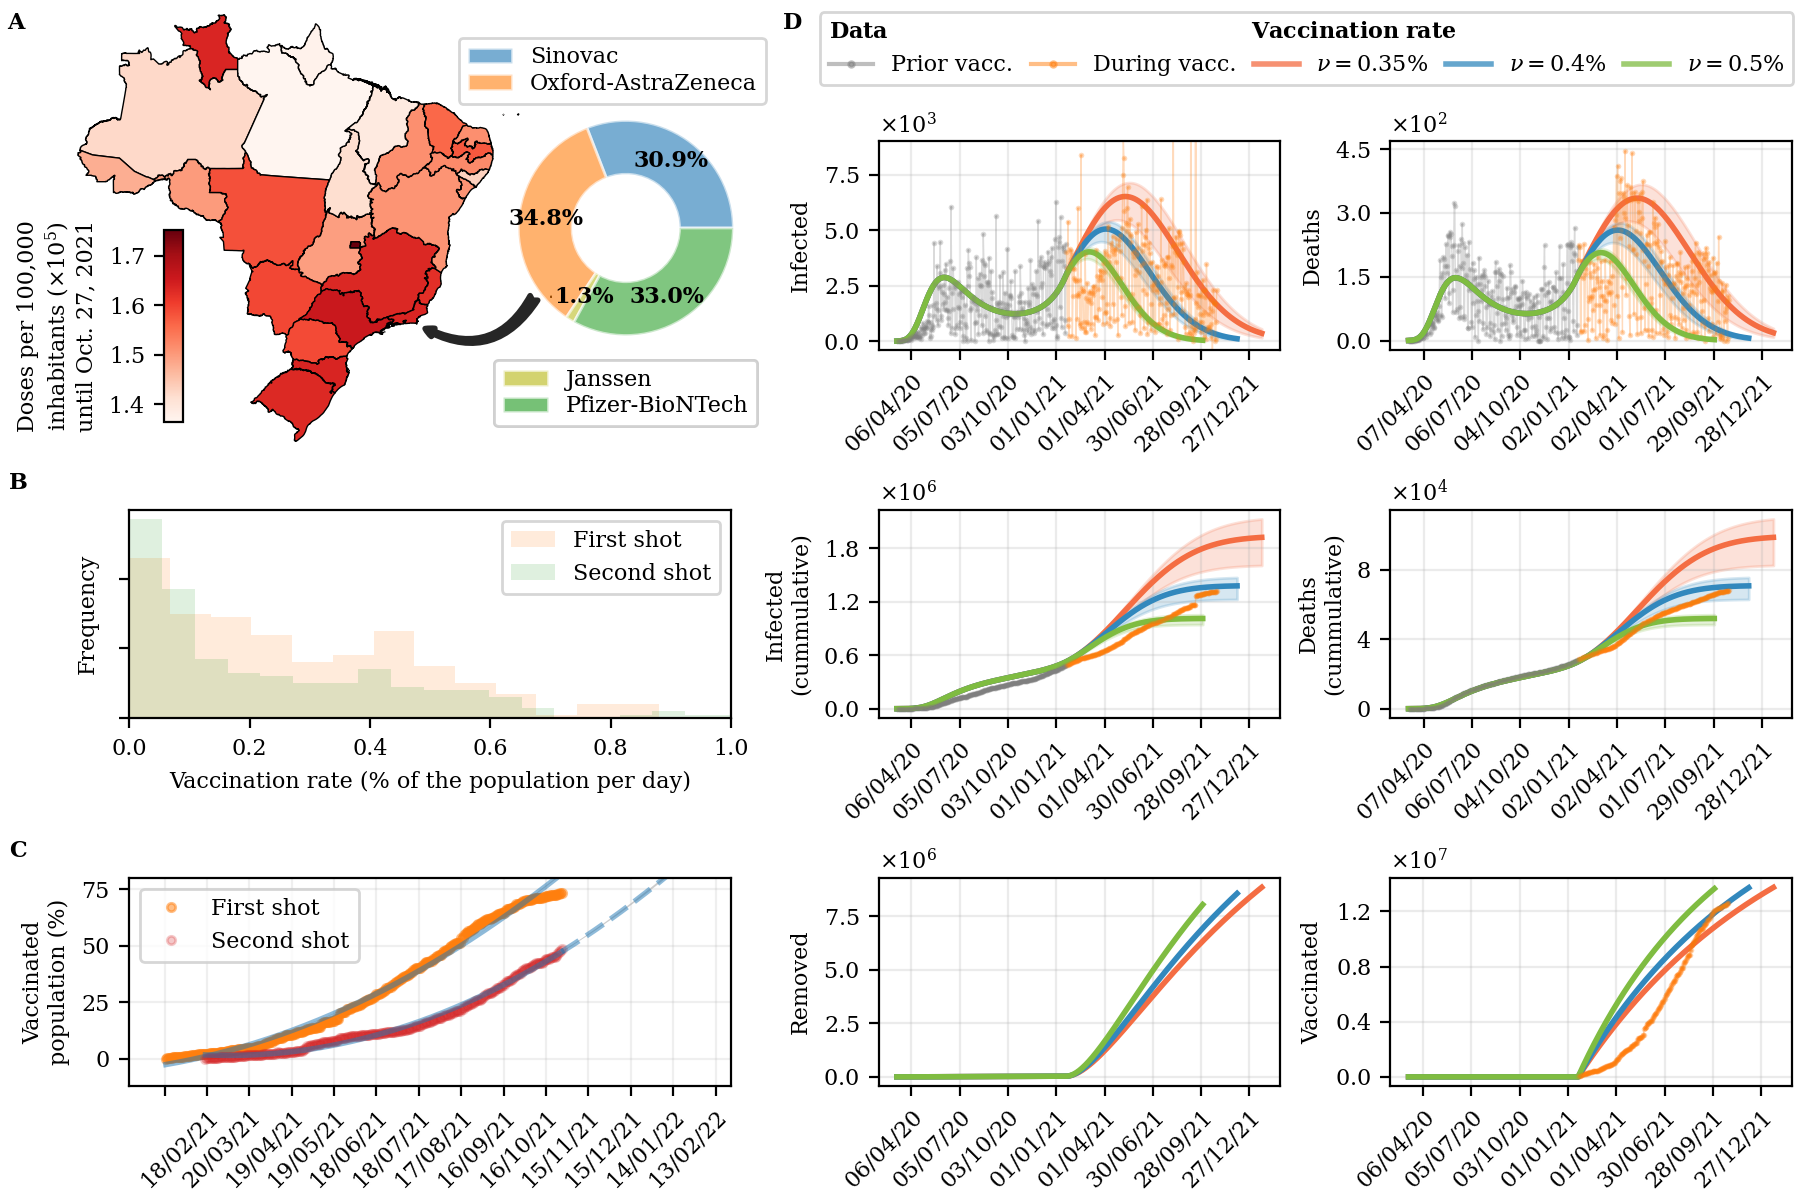

{'PA': 136510, 'AP': 137284, 'MA': 139216, 'TO': 141516, 'AM': 142362, 'AL': 143447, 'AC': 147707, 'GO': 149622, 'RO': 150001, 'BA': 150855, 'SE': 150978, 'PI': 151374, 'RN': 151402, 'PE': 151968, 'CE': 156130, 'PB': 157785, 'MT': 158435, 'PR': 159085, 'MS': 159466, 'ES': 162347, 'RS': 163175, 'MG': 163399, 'RJ': 163561, 'RR': 163692, 'SC': 163758, 'SP': 165782, 'DF': 175195}
BR: 155727.89333621998


<ipython-input-71-cba1951c62b2>:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  state_centroid = INFOS_UFS[INFOS_UFS.sigla == "RJ"].geometry.centroid


First shot, 27/10/21: 73.1910206711948%
Second shot, 27/10/21: 48.32481057134101%
-> Vaccinatio rate: 0.00350
--> Peak of infections: 10/05/21
--> Cases: 1922585 (95% CI: 1607030-2128694)
--> Deaths: 98812 (95% CI: 82596-109401)
-> Vaccinatio rate: 0.00400
--> Peak of infections: 04/04/21
--> Cases: 1378382 (95% CI: 1226446-1472044)
--> Deaths: 70846 (95% CI: 63037-75659)
-> Vaccinatio rate: 0.00500
--> Peak of infections: 04/03/21
--> Cases: 1011948 (95% CI: 944239-1054368)
--> Deaths: 52013 (95% CI: 48532-54193)


In [77]:
ax1 = plt.figure(figsize=(9, 6), constrained_layout=True)
gs1 = ax1.add_gridspec(nrows=7, ncols=7)

ax_doses = ax1.add_subplot(gs1[:3, :3])
plot_map_doses(ax_doses)
ax_doses.text(-0.09, 0.925, "A", transform=ax_doses.transAxes, size=fontsize, weight="bold")

ax_rate_vacc = ax1.add_subplot(gs1[3:5, :3])
plot_hist_vacc_rates(ax_rate_vacc, target_population, vaccinated, vaccinated_second, dates_during_vaccination)
ax_rate_vacc.text(-0.2, 1.1, "B", transform=ax_rate_vacc.transAxes, size=fontsize, weight="bold")

ax_vacc_pred = ax1.add_subplot(gs1[5:7, :3])
plot_vacc_pred(ax_vacc_pred, target_population, vaccinated, data_time_during_vaccination,
               dates_during_vaccination, vaccinated_second)
ax_vacc_pred.text(-0.2, 1.1, "C", transform=ax_vacc_pred.transAxes, size=fontsize, weight="bold")

ax_doses.text(1.4, 0.925, "D", transform=ax_doses.transAxes, size=fontsize, weight="bold")
ax_vacc_sc_1 = ax1.add_subplot(gs1[1:3, 3:5])
ax_vacc_sc_2 = ax1.add_subplot(gs1[3:5, 3:5])
ax_vacc_sc_3 = ax1.add_subplot(gs1[5:, 3:5])
ax_vacc_sc_4 = ax1.add_subplot(gs1[1:3, 5:7])
ax_vacc_sc_5 = ax1.add_subplot(gs1[3:5, 5:7])
ax_vacc_sc_6 = ax1.add_subplot(gs1[5:, 5:7])
ax_vacc_sc = [ax_vacc_sc_1, ax_vacc_sc_2, ax_vacc_sc_3, ax_vacc_sc_4, ax_vacc_sc_5, ax_vacc_sc_6]
plot_vaccination_scenarios_nu(ax_vacc_sc, vaccination_rate, model_sim_vacc_rate, dates_before_vaccination,
                              data_before_vaccination)
# ax_beta_post_3.text(-0.2, -0.95, "f", transform=ax_beta_post_3.transAxes, size=fontsize, weight="bold")

leg = plt.figlegend(handles = [plt.plot([],marker="o", linestyle='solid', color="C7", markersize=2, alpha=0.5)[0],
                         plt.plot([],marker="o", linestyle='solid', color="C1", markersize=2, alpha=0.5)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#f46d43", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#3288bd", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#7fbc41", alpha=0.75)[0]],
                         labels=["Prior vacc.","During vacc.",r"$\nu=0.35\%$",r"$\nu=0.4\%$",r"$\nu=0.5\%$"],
                         title=r"$\mathrm{\bf{Data}\quad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\;\,\bf{Vaccination\;rate}}$",
                         ncol=5,handletextpad=0.8,columnspacing=0.8, bbox_to_anchor=(1.0025, 0.999))
leg._legend_box.align = "left"

plt.savefig(f"{OUTPUT_PATH}/fig1.pdf")

### Supplementary material

<IPython.core.display.Javascript object>


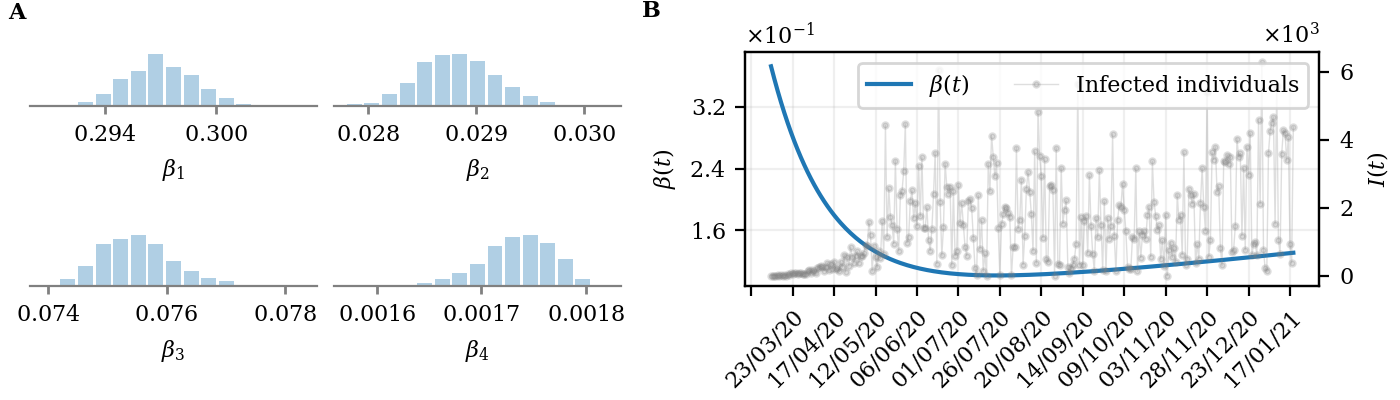

In [78]:
ax11 = plt.figure(figsize=(7, 2), constrained_layout=True)
gs11 = ax11.add_gridspec(nrows=2, ncols=4)

ax_beta_post_1 = ax11.add_subplot(gs11[0, 0])
ax_beta_post_2 = ax11.add_subplot(gs11[0, 1])
ax_beta_post_3 = ax11.add_subplot(gs11[1, 0])
ax_beta_post_4 = ax11.add_subplot(gs11[1, 1])
ax_beta_post = [ax_beta_post_1, ax_beta_post_2, ax_beta_post_3, ax_beta_post_4]
plot_beta_post(ax_beta_post, dict_par_realizations, var_names, fontsize)
ax_beta_post_1.text(-0.075, 1.6, "A", transform=ax_beta_post_1.transAxes, size=fontsize, weight="bold")

ax_beta_t = ax11.add_subplot(gs11[:, 2:])
plot_beta_t(ax_beta_t, par_realizations, var_names, percentile_cut, variable_mpvs, dates_before_vaccination,
            data_time_before_vaccination, infected_individuals_before_vaccination)
ax_beta_t.text(-0.18, 1.15, "B", transform=ax_beta_t.transAxes, size=fontsize, weight="bold")

plt.savefig(f"{OUTPUT_PATH}/beta_opt.pdf")

----
## What would be the influence of bringing forward or delaying the vaccination roll-out?
### Function to plot scenarios regarding rollout

In [79]:
def plot_scenarios_rollout(ax, vacc_rate, model_sim_scenario_analysis, fontsize):
    qoi_analysis = ["I", "D"]
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [10, 20, 30]
    
    colors = ["#e31a1c", "#bd0026", "#800026", "#fd8d3c", "#feb24c", "#fed976", "#fc4e2a"]
    
    print("Figure 2a\n")
    
    for (i, nu) in enumerate(np.flip(vacc_rate)):
        print(f"\n-> Vaccination rate: {nu:.5f}")
        if nu == vacc_rate[0]:
            interval = 100
        elif nu == vacc_rate[1]:
            interval = 80
        elif nu == vacc_rate[2]:
            interval = 60
        for (j, qoi) in enumerate(qoi_analysis):
            print(f"--> QoI: {qoi}")
            for m, scenario in enumerate(scenario_analysis):
                print(f"---> Scenario: {scenario}")
                for n, day in enumerate(days_scenario_analysis):
                    print(f"----> Days: {day}")
                    k = int((3 * m) + n)
                    
                    qoi_map = model_sim_scenario_analysis[scenario][day][nu][qoi]["map"]
                    qoi_min = model_sim_scenario_analysis[scenario][day][nu][qoi]["min"]
                    qoi_max = model_sim_scenario_analysis[scenario][day][nu][qoi]["max"]
                    dates = model_sim_scenario_analysis[scenario][day][nu]["dates"]
                    
                    six_months_mean = qoi_map[days_before_vaccination + 180]
                    six_months_min = qoi_min[days_before_vaccination + 180]
                    six_months_max = qoi_max[days_before_vaccination + 180]
                    if qoi == "D":
                        dates = dates[:-1]
                        print(f"-----> After six months: {six_months_mean:.0f} deaths (95% CI: {six_months_min:.0f}-{six_months_max:.0f})")
                        
                        if nu == vacc_rate[1] and scenario == "delayed" and day == 30:
                            peak_day_delayed = np.argmax(qoi_map)
                            print(f"-----> Peak of deaths: {dates[peak_day_delayed]}")
                            print(f"-----> Deaths on {dates[peak_day_delayed]}: {qoi_map[peak_day_delayed]:.0f} (95% CI: {qoi_min[peak_day_delayed]:.0f}-{qoi_max[peak_day_delayed]:.0f})")
                        if nu == vacc_rate[1] and scenario == "advanced" and day == 30:
                            print(f"-----> Deaths on {dates[peak_day_delayed]}: {qoi_map[peak_day_delayed]:.0f} (95% CI: {qoi_min[peak_day_delayed]:.0f}-{qoi_max[peak_day_delayed]:.0f})")
                            peak_day_advanced = np.argmax(qoi_map)
                            print(f"-----> Peak of deaths: {dates[peak_day_advanced]}")
                            print(f"-----> Deaths on {dates[peak_day_advanced]}: {qoi_map[peak_day_advanced]:.0f} (95% CI: {qoi_min[peak_day_advanced]:.0f}-{qoi_max[peak_day_advanced]:.0f})")
                    
                    if qoi == "I":
                        print(f"-----> After six months: {six_months_mean:.0f} cases (95% CI: {six_months_min:.0f}-{six_months_max:.0f})")

                    ax[j][i].plot(dates, qoi_map, color=colors[k])
                    ax[j][i].fill_between(dates, qoi_min, qoi_max, color=colors[k], alpha=0.2)

            qoi_map = model_sim_scenario_analysis["ontime"][0][nu][qoi]["map"]
            qoi_min = model_sim_scenario_analysis["ontime"][0][nu][qoi]["min"]
            qoi_max = model_sim_scenario_analysis["ontime"][0][nu][qoi]["max"]
            dates = model_sim_scenario_analysis["ontime"][0][nu]["dates"]
            
            six_months_mean = qoi_map[days_before_vaccination + 180]
            six_months_min = qoi_min[days_before_vaccination + 180]
            six_months_max = qoi_max[days_before_vaccination + 180]
            if qoi == "D":
                dates = dates[:-1]
                print(f"-----> Scenario: ontime, after six months: {six_months_mean:.0f} deaths (95% CI: {six_months_min:.0f}-{six_months_max:.0f})")
            
            if qoi == "I":
                print(f"-----> Scenario: ontime, after six months: {six_months_mean:.0f} cases (95% CI: {six_months_min:.0f}-{six_months_max:.0f})")

            ax[j][i].plot(dates, qoi_map, color=colors[-1])
            ax[j][i].fill_between(dates, qoi_min, qoi_max, color=colors[-1], alpha=0.2)

            ax[j][i].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
            ax[j][i].yaxis.major.formatter._useMathText = True
            ax[j][i].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
            plt.setp(ax[j][i].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            ax[j][i].yaxis.set_major_locator(plt.MaxNLocator(4))
            ax[j][i].grid(alpha=0.25)
            
            ind_start_date = dates.index("20/01/21")
            ind_post_date = dates.index("20/07/21")
            ax[j][i].fill_between(dates[ind_start_date:ind_post_date],
                                  ax[j][i].get_ybound()[0],
                                  ax[j][i].get_ybound()[1],
                                  alpha=0.15,
                                  color="C7")

    ax[0][0].set_xticklabels([])
    ax[0][1].set_xticklabels([])
    ax[0][2].set_xticklabels([])

    ax[0][2].set_title(r"$\nu = 0.35\%$", fontsize=fontsize)
    ax[0][1].set_title(r"$\nu = 0.4\%$", fontsize=fontsize)
    ax[0][0].set_title(r"$\nu = 0.5\%$", fontsize=fontsize)

    ax[0][0].set_ylabel(r"$I(t)$", fontsize=fontsize)
    ax[1][0].set_ylabel(r"$D(t)$", fontsize=fontsize)
    
    ax[0][0].legend(handles = [plt.plot([],linestyle='solid', linewidth=2, color=colors[2])[0],
                     plt.plot([],linestyle='solid', linewidth=2, color=colors[1])[0],
                     plt.plot([],linestyle='solid', linewidth=2, color=colors[0])[0],
                     plt.plot([],linestyle='solid', linewidth=2, color=colors[3])[0],
                     plt.plot([],linestyle='solid', linewidth=2, color=colors[4])[0],
                     plt.plot([],linestyle='solid', linewidth=2, color=colors[5])[0]],
                     labels=[r"$30\rightarrow$", r"$20\rightarrow$", r"$10\rightarrow$",
                             r"$10\leftarrow$", r"$20\leftarrow$", r"$30\leftarrow$"],
                     loc='upper left',ncol=2,handletextpad=0.45,columnspacing=0.75,handlelength=1,labelspacing=0.25)

### Function to plot cumulative deaths and infections

In [80]:
def plot_cumm_qoi(ax, vacc_rate, model_sim_scenario_analysis, fontsize):
    qoi_analysis = ["C", "D"]
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [10, 20, 30]
    
    print("\n\nFigure 2b\n")

    for i, qoi in enumerate(qoi_analysis):
        print(f"--> QoI: {qoi}")
        for nu in vacc_rate:
            print(f"\n-> Vaccination rate: {nu:.5f}")
            if nu == vacc_rate[0]:
                color = "C0"
            elif nu == vacc_rate[1]:
                color = "C1"
            elif nu == vacc_rate[2]:
                color = "C2"
            for scenario in scenario_analysis:
                print(f"---> Scenario: {scenario}")
                for day in days_scenario_analysis:
                    print(f"----> Days: {day}")
                    x = [day] if scenario == "advanced" else [-day]
                    if qoi == "C":
                        sim_qoi = model_sim_scenario_analysis[scenario][day][nu]["I"]
                        y = np.cumsum(sim_qoi["map"])[-1]
                        y_min = np.cumsum(sim_qoi["min"])[-1]
                        y_max = np.cumsum(sim_qoi["max"])[-1]
                        
                        yerr = [[y - y_min], [y_max - y]]
                        (ax[i]).errorbar(x=x, y=y, yerr=yerr, fmt="-o", color=color,
                                         capsize=4, markersize=3, markerfacecolor="black",
                                         markeredgecolor="black")
                        
                        print(f"-----> Cases: {y:.0f} (95% CI: {y_min:.0f}-{y_max:.0f})")
                    elif qoi == "D":
                        sim_qoi = model_sim_scenario_analysis[scenario][day][nu][qoi]
                        y = np.cumsum(sim_qoi["map"])[-1]
                        y_min = np.cumsum(sim_qoi["min"])[-1]
                        y_max = np.cumsum(sim_qoi["max"])[-1]
                        
                        yerr = [[y - y_min], [y_max - y]]
                        (ax[i]).errorbar(x=x, y=y, yerr=yerr, fmt="-o", color=color,
                                         capsize=4, markersize=3, markerfacecolor="black",
                                         markeredgecolor="black")
                        
                        print(f"-----> Deaths: {y:.0f} (95% CI: {y_min:.0f}-{y_max:.0f})")
                        
            x = [0]
            if qoi == "C":
                sim_qoi = model_sim_scenario_analysis["ontime"][0][nu]["I"]
                y = np.cumsum(sim_qoi["map"])[-1]
                y_min = np.cumsum(sim_qoi["min"])[-1]
                y_max = np.cumsum(sim_qoi["max"])[-1]
                
                yerr = [[y - np.cumsum(sim_qoi["min"])[-1]],
                       [np.cumsum(sim_qoi["max"])[-1] - y]]
                (ax[i]).errorbar(x=x, y=y, yerr=yerr, fmt="-o", color=color, capsize=4,
                                 markersize=3, markerfacecolor="black", markeredgecolor="black")
                print(f"-----> Cases: {y:.0f} (95% CI: {y_min:.0f}-{y_max:.0f})")
            elif qoi == "D":
                sim_qoi = model_sim_scenario_analysis["ontime"][0][nu][qoi]
                y = np.cumsum(sim_qoi["map"])[-1]
                y_min = np.cumsum(sim_qoi["min"])[-1]
                y_max = np.cumsum(sim_qoi["max"])[-1]
                    
                yerr = [[y - np.cumsum(sim_qoi["min"])[-1]],
                       [np.cumsum(sim_qoi["max"])[-1] - y]]
                (ax[i]).errorbar(x=x, y=y, yerr=yerr, fmt="-o", color=color, capsize=4,
                                 markersize=3, markerfacecolor="black", markeredgecolor="black")
                print(f"-----> Deaths: {y:.0f} (95% CI: {y_min:.0f}-{y_max:.0f})")

        (ax[i]).set_yscale("log")
#         (ax[i]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
#         (ax[i]).yaxis.major.formatter._useMathText = True
        if i == 0:
            ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/1e6))
            (ax[i]).yaxis.set_major_formatter(ticks_y)
            (ax[i]).yaxis.set_minor_formatter(ticks_y)
            (ax[i]).yaxis.set_minor_locator(plt.MaxNLocator(7))
        else:
            ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/1e5))
            (ax[i]).yaxis.set_major_formatter(ticks_y)
            (ax[i]).yaxis.set_minor_formatter(ticks_y)
            (ax[i]).yaxis.set_minor_locator(plt.MaxNLocator(6))
        
        (ax[i]).xaxis.set_major_locator(plt.MaxNLocator(7))
        
        (ax[i]).grid(alpha=0.25, which='both')

    (ax[0]).set_xlabel("Start of vaccination\n(as of January 20, 2021)", fontsize=fontsize)
    (ax[1]).set_xlabel("Start of vaccination\n(as of January 20, 2021)", fontsize=fontsize)

    (ax[0]).set_ylabel("Cumulative infections", fontsize=fontsize)
    (ax[1]).set_ylabel("Cumulative deaths", fontsize=fontsize)
    
    (ax[0]).set_title(r"$\times 10^{6}$", loc="left", pad=3, fontsize=fontsize)
    (ax[1]).set_title(r"$\times 10^{5}$", loc="left", pad=3, fontsize=fontsize)
    
    ax[0].legend(handles = [plt.plot([],linestyle='solid', linewidth=1, color="C0")[0],
                 plt.plot([],linestyle='solid', linewidth=1, color="C1")[0],
                 plt.plot([],linestyle='solid', linewidth=1, color="C2")[0]],
                 labels=[r"$\nu=0.35\%$",r"$\nu=0.40\%$",r"$\nu=0.50\%$"],
                 loc='upper right',ncol=1,handletextpad=0.5,columnspacing=0.6,handlelength=0.8)

### Function to plot $ W(t) \times D(t) $

In [81]:
def plot_WD(ax, vacc_rate, model_sim_delayed, model_sim_advanced, days_before_vacc, fontsize):
    scenario_analysis = ["advanced", "delayed"]
    print("\n\nFigure 2c\n")
    
    for k, scenario in enumerate(scenario_analysis):
        print(f"-> Scenario: {scenario}")
        if scenario == "delayed":
            model_sim = model_sim_delayed
        elif scenario == "advanced":
            model_sim = model_sim_advanced
        for nu in vacc_rate:
            print(f"--> Vaccination rate: {nu:.5f}")
            if nu == vacc_rate[0]:
                color="C0"
            elif nu == vacc_rate[1]:
                color="C1"
            elif nu == vacc_rate[2]:
                color="C2"

            W_map = model_sim[nu]["W"]["map"][:-1]

            qoi_map = model_sim[nu]["D"]["map"]
            qoi_min = model_sim[nu]["D"]["min"]
            qoi_max = model_sim[nu]["D"]["max"]

            ax[k].plot(W_map, qoi_map, color=color)
            ax[k].fill_between(W_map, qoi_min, qoi_max, color=color, alpha=0.2)

            if nu == vacc_rate[0]:
                y_lim = ax[k].get_ylim()

            idx_shift = 200
            max_idx_qoi = np.where(qoi_map == np.amax(qoi_map[idx_shift:]))[0][0]
            W_max_qoi = W_map[max_idx_qoi]
            ax[k].plot(W_max_qoi * np.ones(2), ax[k].get_ylim(), "--", color=color)
            
            sim_dates = model_sim[nu]["dates"]
            if scenario == "delayed":
                print(f"---> Deaths on {sim_dates[days_before_vacc + 30]}: {qoi_map[days_before_vacc + 30]:.0f} (95% CI: {qoi_min[days_before_vacc + 30]:.0f}-{qoi_max[days_before_vacc + 30]:.0f})")
                peak_day_delayed = np.argmax(qoi_map)
                print(f"---> Peak of deaths: {sim_dates[peak_day_delayed]} at {qoi_map[peak_day_delayed]:.0f} (95% CI: {qoi_min[peak_day_delayed]:.0f}-{qoi_max[peak_day_delayed]:.0f})")
                W_min = model_sim[nu]["W"]["min"]
                W_max = model_sim[nu]["W"]["max"]
                print(f"---> People vaccinated at {sim_dates[peak_day_delayed]}: {W_map[peak_day_delayed]:.0f} (95% CI: {W_min[peak_day_delayed]:.0f}-{W_max[peak_day_delayed]:.0f})")
            elif scenario == "advanced":
                print(f"---> Deaths on {sim_dates[days_before_vacc - 30]}: {qoi_map[days_before_vacc - 30]:.0f} (95% CI: {qoi_min[days_before_vacc - 30]:.0f}-{qoi_max[days_before_vacc + 30]:.0f})")
                peak_day_advanced = np.argmax(qoi_map)
                print(f"---> Peak of deaths: {sim_dates[peak_day_advanced]} at {qoi_map[peak_day_advanced]:.0f} (95% CI: {qoi_min[peak_day_advanced]:.0f}-{qoi_max[peak_day_advanced]:.0f})")
                W_min = model_sim[nu]["W"]["min"]
                W_max = model_sim[nu]["W"]["max"]
                print(f"---> People vaccinated at {sim_dates[peak_day_advanced]}: {W_map[peak_day_advanced]:.0f} (95% CI: {W_min[peak_day_advanced]:.0f}-{W_max[peak_day_advanced]:.0f})")
            
            # print(qoi_map[max_idx_qoi], model_sim[nu]["I"]["map"][max_idx_qoi], model_sim[nu]["dates"][np.where(W_map > 0)[0][0]])
            # print(qoi_min[max_idx_qoi], model_sim[nu]["I"]["min"][max_idx_qoi])
            # print(qoi_max[max_idx_qoi], model_sim[nu]["I"]["max"][max_idx_qoi])
            # print(W_map[max_idx_qoi])
            # print("-----")

        ax[k].yaxis.set_major_locator(plt.MaxNLocator(4))
        # ax[k].set_xlim((ax[k].get_xlim()[0], 1e7))
        ax[k].set_ylim(y_lim)

        ax[k].ticklabel_format(axis='x', useOffset=True, scilimits=(0,0))
        ax[k].xaxis.major.formatter._useMathText = True
        
        (ax[k]).grid(alpha=0.2)
    
    ax[0].set_ylabel(r"$D\left(t\right)$")
    ax[1].set_ylabel(r"$D\left(t\right)$")

    ax[0].set_title("Start of vaccination 30 days earlier", loc="center", fontsize=fontsize)
    ax[1].set_title("Start of vaccination 30 days later", loc="center", fontsize=fontsize)
    ax[0].set_xlabel(r"$W\left(t\right)$")
    ax[1].set_xlabel(r"$W\left(t\right)$")
    
    ax[0].legend(handles = [plt.plot([],linestyle='solid', linewidth=1, color="C0")[0],
                 plt.plot([],linestyle='solid', linewidth=1, color="C1")[0],
                 plt.plot([],linestyle='solid', linewidth=1, color="C2")[0]],
                 labels=[r"$\nu=0.35\%$",r"$\nu=0.4\%$",r"$\nu=0.5\%$"],
                 loc='upper right',ncol=1)

### Function to plot $\mathcal{R}(t)$

In [82]:
def plot_Rt(ax, vacc_rate, num_vaccines, model_sim_scenario_analysis, days_before_vacc,
            pop_size, gamma, rho, variable_mpvs, fontsize):
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [30]
    
    print("\n\nFigure 2d\n")
        
    for i, scenario in enumerate(scenario_analysis):
        print(f"-> Scenario: {scenario}")
        for j, day in enumerate(days_scenario_analysis):
            for k, nu in enumerate(vacc_rate):
                print(f"--> Vaccination rate: {nu:.5f}")
                sum_vaccines = sum(list(num_vaccines))
                nu1, nu2, nu3, nu4 = tuple((num_vacc / sum_vaccines) * nu for num_vacc in num_vaccines)

                dates = model_sim_scenario_analysis[scenario][day][nu]["dates"]

                St = model_sim_scenario_analysis[scenario][day][nu]["S"]["map"]
                time_span = np.linspace(start=0, stop=len(St), num=len(St), endpoint=True)
                Rt = sim_Rt(time_span, days_before_vacc, scenario, day, pop_size, gamma, rho, nu1, nu2, nu3, nu4, St, *list(variable_mpvs.values()))

                St_min = model_sim_scenario_analysis[scenario][day][nu]["S"]["min"]
                Rt_min = sim_Rt(time_span, days_before_vacc, scenario, day, pop_size, gamma, rho, nu1, nu2, nu3, nu4, St_min, *list(variable_mpvs.values()))
                St_max = model_sim_scenario_analysis[scenario][day][nu]["S"]["max"]
                Rt_max = sim_Rt(time_span, days_before_vacc, scenario, day, pop_size, gamma, rho, nu1, nu2, nu3, nu4, St_max, *list(variable_mpvs.values()))

                ax[i].plot(dates, Rt)
                ax[i].fill_between(dates, Rt_min, Rt_max, alpha=0.2)
                
                if scenario == "delayed":
                    (ax[0]).annotate("Vaccination\nstarts",
                                    xy=(days_before_vacc + day, 1.25), xycoords='data',
                                    xytext=(600, 1.2), textcoords='data',
                                    size=fontsize, va="center", ha="center",
                                    arrowprops=dict(arrowstyle="simple",
                                                    connectionstyle="arc3,rad=0.5",
                                                    facecolor="black",
                                                    edgecolor="black",
                                                    alpha=0.25,
                                                    linewidth=0.5),fontsize=fontsize)
                
                days_Rt_less_one = np.where(Rt < 1)[0]
                days_Rt_less_one_before_vacc = np.where(days_Rt_less_one < days_before_vacc)[0] + days_Rt_less_one[0]
                print(f"---> R(t) < 1 before vaccination: {dates[days_Rt_less_one_before_vacc[0]]}-{dates[days_Rt_less_one_before_vacc[-1]]}")
                
                day_min_Rt_before_vacc = np.argmin(Rt[:days_before_vacc])
                val_min_Rt_before_vacc = np.min(Rt[:days_before_vacc])
                date_min_Rt_before_vacc = dates[day_min_Rt_before_vacc]
                print(f"---> Min R(t) before vaccination: {date_min_Rt_before_vacc} at {val_min_Rt_before_vacc}")
                
                I_map = model_sim_scenario_analysis[scenario][day][nu]["I"]["map"]
                I_min = model_sim_scenario_analysis[scenario][day][nu]["I"]["min"]
                I_max = model_sim_scenario_analysis[scenario][day][nu]["I"]["max"]
                if scenario == "delayed":
                    start_vacc = days_before_vacc + 31
                elif scenario == "advanced":
                    start_vacc = days_before_vacc - 31
                print(f"---> Cases on the day vaccination started: {I_map[start_vacc]:.0f} (95% CI: {I_min[start_vacc]:.0f}-{I_max[start_vacc]:.0f})")
                
                days_Rt_less_one_during_vacc = days_Rt_less_one[np.where(days_Rt_less_one > days_before_vacc)[0]]
                print(f"---> R(t) < 1 during vaccination: {dates[days_Rt_less_one_during_vacc[0]]}-{dates[days_Rt_less_one_during_vacc[-1]]}")
                
                W_map = model_sim_scenario_analysis[scenario][day][nu]["W"]["map"]
                W_min = model_sim_scenario_analysis[scenario][day][nu]["W"]["min"]
                W_max = model_sim_scenario_analysis[scenario][day][nu]["W"]["max"]
                pct_map_vaccinated = (W_map[days_Rt_less_one_during_vacc[0]] / (0.8 * pop_size)) * 100
                pct_min_vaccinated = (W_min[days_Rt_less_one_during_vacc[0]] / (0.8 * pop_size)) * 100
                pct_max_vaccinated = (W_max[days_Rt_less_one_during_vacc[0]] / (0.8 * pop_size)) * 100
                print(f"---> % of elegible population vaccinated on {dates[days_Rt_less_one_during_vacc[0]]}: {pct_map_vaccinated:.2f} (95% CI: {pct_min_vaccinated:.2f}-{pct_max_vaccinated:.2f})")
                print(f"---> R(t) = {Rt[start_vacc-1]:.3f} (95% CI: {Rt_min[start_vacc-1]:.3f}-{Rt_max[start_vacc-1]:.3f}) on the day vaccination started")
                
        ax[i].text(ax[i].get_xlim()[1] - 0.1 * ax[i].get_xlim()[1], 1,
                   r"$\mathcal{R}\left(t\right)=1$",
                   horizontalalignment='center',
                   bbox=dict(boxstyle="square", ec="C7", fc="white",))

        ax[i].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        ax[i].yaxis.major.formatter._useMathText = True
        
        ax[i].plot(ax[i].get_xlim(), [1, 1], "--", color="C7")
        ax[i].set_xlim(ax[i].get_xlim())

        ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=90))
        plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax[i].grid(alpha=0.25)
        ax[i].set_ylim(0.75, 1.35)
        
        ax[i].set_ylabel(r"$\mathcal{R}\left(t\right)$")
        ax[i].set_xlabel("")
        
    ax[0].yaxis.set_major_locator(plt.MaxNLocator(6))
    ax[1].yaxis.set_major_locator(plt.MaxNLocator(6))
        
    ax[0].set_title("Start of vaccination 30 days later", loc="center", fontsize=fontsize)
    ax[1].set_title("Start of vaccination 30 days earlier", loc="center", fontsize=fontsize)
        

## Plotting all together

<IPython.core.display.Javascript object>


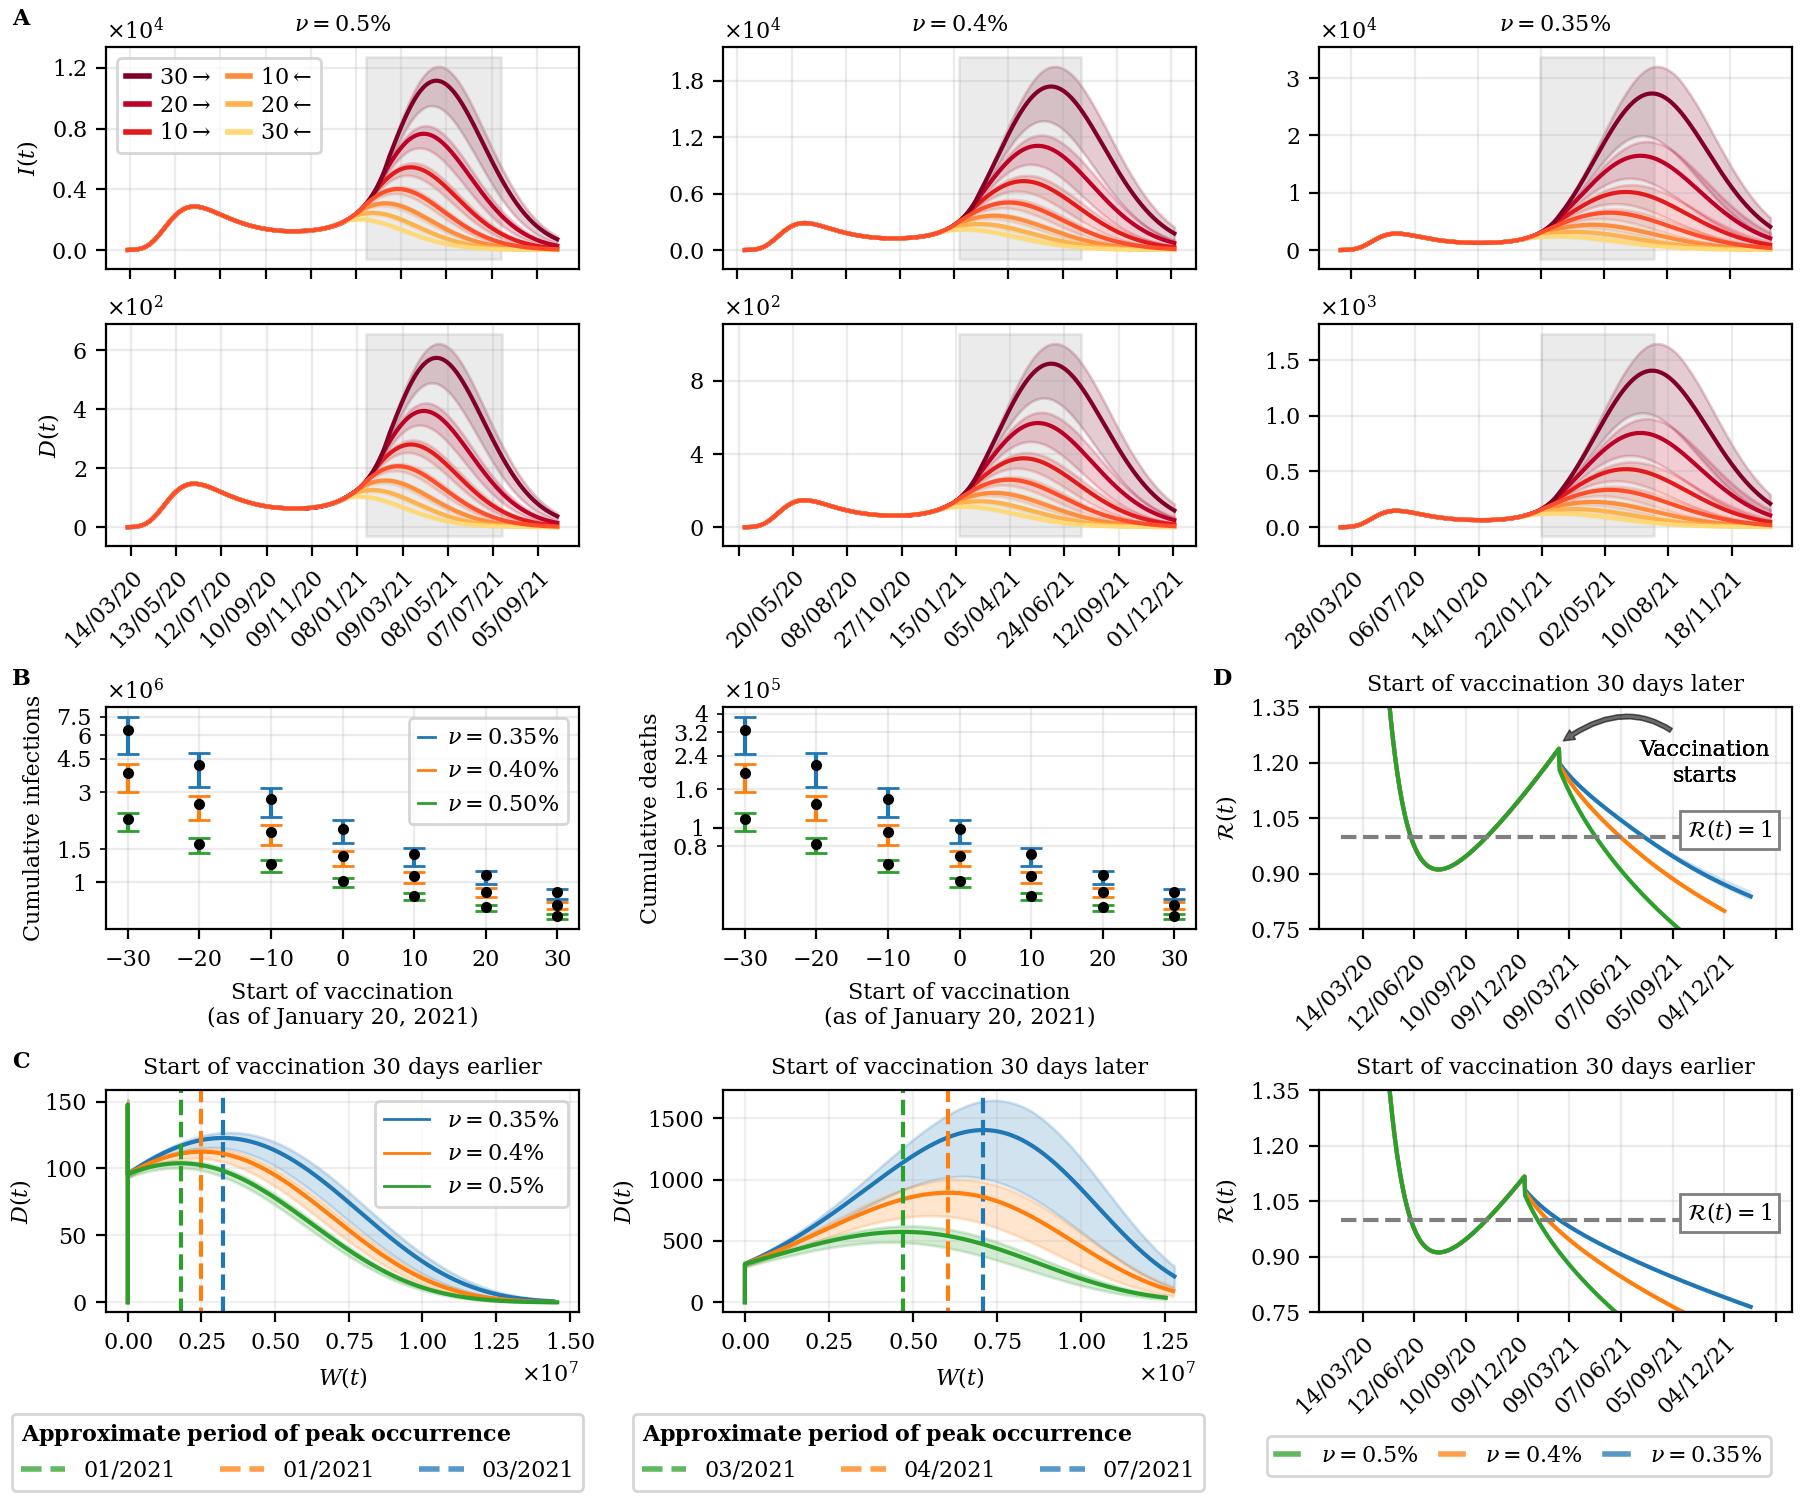

Figure 2a


-> Vaccination rate: 0.00500
--> QoI: I
---> Scenario: delayed
----> Days: 10
-----> After six months: 1064 cases (95% CI: 780-1231)
----> Days: 20
-----> After six months: 2263 cases (95% CI: 1649-2634)
----> Days: 30
-----> After six months: 4667 cases (95% CI: 3389-5454)
---> Scenario: advanced
----> Days: 10
-----> After six months: 217 cases (95% CI: 162-250)
----> Days: 20
-----> After six months: 95 cases (95% CI: 72-109)
----> Days: 30
-----> After six months: 41 cases (95% CI: 31-47)
-----> Scenario: ontime, after six months: 486 cases (95% CI: 360-560)
--> QoI: D
---> Scenario: delayed
----> Days: 10
-----> After six months: 54 deaths (95% CI: 40-63)
----> Days: 20
-----> After six months: 115 deaths (95% CI: 84-134)
----> Days: 30
-----> After six months: 238 deaths (95% CI: 172-278)
---> Scenario: advanced
----> Days: 10
-----> After six months: 11 deaths (95% CI: 8-13)
----> Days: 20
-----> After six months: 5 deaths (95% CI: 4-6)
----> Days: 30
-----> After si

---> R(t) < 1 before vaccination: 07/06/20-16/10/20
---> Min R(t) before vaccination: 24/07/20 at 0.9118066964173881
---> Cases on the day vaccination started: 1834 (95% CI: 1786-1862)
---> R(t) < 1 during vaccination: 20/02/21-19/01/22
---> % of elegible population vaccinated on 20/02/21: 24.19 (95% CI: 24.18-24.20)
---> R(t) = 1.113 (95% CI: 1.113-1.113) on the day vaccination started
--> Vaccination rate: 0.00400
---> R(t) < 1 before vaccination: 07/06/20-16/10/20
---> Min R(t) before vaccination: 24/07/20 at 0.9118066335082162
---> Cases on the day vaccination started: 1834 (95% CI: 1786-1862)
---> R(t) < 1 during vaccination: 31/01/21-04/12/21
---> % of elegible population vaccinated on 31/01/21: 18.95 (95% CI: 18.95-18.97)
---> R(t) = 1.113 (95% CI: 1.113-1.113) on the day vaccination started
--> Vaccination rate: 0.00500
---> R(t) < 1 before vaccination: 07/06/20-23/10/20
---> Min R(t) before vaccination: 24/07/20 at 0.9118065505240966
---> Cases on the day vaccination started: 

In [83]:
ax2 = plt.figure(figsize=(9, 7.5), constrained_layout=True)
gs2 = ax2.add_gridspec(nrows=13, ncols=3)

ax_scenarios_rollout_1 = ax2.add_subplot(gs2[0:3, 0])
ax_scenarios_rollout_2 = ax2.add_subplot(gs2[0:3, 1])
ax_scenarios_rollout_3 = ax2.add_subplot(gs2[0:3, 2])
ax_scenarios_rollout_4 = ax2.add_subplot(gs2[3:6, 0])
ax_scenarios_rollout_5 = ax2.add_subplot(gs2[3:6, 1])
ax_scenarios_rollout_6 = ax2.add_subplot(gs2[3:6, 2])
ax_scenarios_rollout = ((ax_scenarios_rollout_1, ax_scenarios_rollout_2, ax_scenarios_rollout_3),
                        (ax_scenarios_rollout_4, ax_scenarios_rollout_5, ax_scenarios_rollout_6))
plot_scenarios_rollout(ax_scenarios_rollout, vaccination_rate, model_sim_scenario_analysis, fontsize)
ax_scenarios_rollout_1.text(-0.2, 1.1, "A", transform=ax_scenarios_rollout_1.transAxes, size=fontsize, weight="bold")

ax_cumm_qoi_1 = ax2.add_subplot(gs2[6:9, 0])
ax_cumm_qoi_2 = ax2.add_subplot(gs2[6:9, 1])
ax_cumm_qoi = [ax_cumm_qoi_1, ax_cumm_qoi_2]
plot_cumm_qoi(ax_cumm_qoi, vaccination_rate, model_sim_scenario_analysis, fontsize)
ax_cumm_qoi_1.text(-0.2, 1.1, "B", transform=ax_cumm_qoi_1.transAxes, size=fontsize, weight="bold")

ax_wd_1 = ax2.add_subplot(gs2[9:12, 0])
ax_wd_2 = ax2.add_subplot(gs2[9:12, 1])
ax_wd = [ax_wd_1, ax_wd_2]
plot_WD(ax_wd, vaccination_rate, model_sim_delayed, model_sim_advanced, days_before_vaccination, fontsize)
ax_wd_1.text(-0.2, 1.1, "C", transform=ax_wd_1.transAxes, size=fontsize, weight="bold")
leg1 = plt.figlegend(handles = [plt.plot([],linestyle='dashed', linewidth=2, color="C2", alpha=0.75)[0],
                                plt.plot([],linestyle='dashed', linewidth=2, color="C1", alpha=0.75)[0],
                                plt.plot([],linestyle='dashed', linewidth=2, color="C0", alpha=0.75)[0]],
                     labels=["03/2021","04/2021","07/2021"],
                     title=r"$\mathrm{\bf{Approximate\;period\;of\;peak\;occurrence}}$",
                     ncol=3, bbox_to_anchor=(0.675, 0.065))
leg1._legend_box.align = "left"

leg2 = plt.figlegend(handles = [plt.plot([],linestyle='dashed', linewidth=2, color="C2", alpha=0.75)[0],
                                plt.plot([],linestyle='dashed', linewidth=2, color="C1", alpha=0.75)[0],
                                plt.plot([],linestyle='dashed', linewidth=2, color="C0", alpha=0.75)[0]],
                     labels=["01/2021","01/2021","03/2021"],
                     title=r"$\mathrm{\bf{Approximate\;period\;of\;peak\;occurrence}}$",
                     ncol=3, bbox_to_anchor=(0.33, 0.065))
leg2._legend_box.align = "left"

ax_Rt_1 = ax2.add_subplot(gs2[6:9, 2])
ax_Rt_2 = ax2.add_subplot(gs2[9:12, 2])
ax_Rt = [ax_Rt_1, ax_Rt_2]
plot_Rt(ax_Rt, vaccination_rate, num_vaccines, model_sim_scenario_analysis, days_before_vaccination,
        target_population, gamma, rho, variable_mpvs, fontsize)
plt.figlegend(handles = [plt.plot([],linestyle='solid', linewidth=2, color="C2", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="C1", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="C0", alpha=0.75)[0]],
                         labels=[r"$\nu=0.5\%$",r"$\nu=0.4\%$",r"$\nu=0.35\%$"],
                         ncol=3, bbox_to_anchor=(0.99, 0.05), handletextpad=1,columnspacing=1,handlelength=1)
ax_Rt_1.text(-0.225, 1.1, "D", transform=ax_Rt_1.transAxes, size=fontsize, weight="bold")

plt.savefig(f"{OUTPUT_PATH}/fig2.pdf")

---
## How harmful is the choice of part of the population for not getting vaccinated?
### Function to plot scenarios with limited number of vaccinated individuals

In [84]:
def plot_scenarios_limited(axs, vacc_rate, model_sim_limited_doses, dates_before_vacc, dates_during_vacc,
                           data_before_vacc, data_during_vacc, pop_size, days_before_vacc, fontsize):
    ax_labels = ["W", "I", "D"]
    
    print("\n\nFigure 3a\n")
    
    for nu in vacc_rate:
        print(f"\n-> Vaccination rate: {nu:.5f}")
        if nu == vacc_rate[0]:
            color = "#f46d43"
        elif nu == vacc_rate[1]:
            color = "#3288bd"
        elif nu == vacc_rate[2]:
            color = "#7fbc41"

        for k, label in enumerate(ax_labels):
            print(f"--> QoI: {label}")
            dates = model_sim_limited_doses[nu]["dates"]
            
            if label == "D" or label == "Dc":
                dates = dates[:-1]
                
                if label == "Dc":
                    label = "D"
                
                    axs[k].plot(
                        dates,
                        np.cumsum(model_sim_limited_doses[nu][label]["map"]),
                        color=color,
                        marker="o",
                        linestyle="-",
                        markersize=0,
                        linewidth=2,
                    )

                    axs[k].fill_between(
                        dates,
                        np.cumsum(model_sim_limited_doses[nu][label]["min"]),
                        np.cumsum(model_sim_limited_doses[nu][label]["max"]),
                        alpha=0.2,
                        color=color
                    )
                    
                else:
                    axs[k].plot(dates_before_vacc,
                                data_before_vacc[1],
                                marker="o",
                                markersize=1,
                                color="C7",
                                alpha=0.1,
                                linewidth=0.5)
                    axs[k].plot(dates_during_vacc,
                                data_during_vacc[1],
                                marker="o",
                                markersize=1,
                                color="C1",
                                alpha=0.1,
                                linewidth=0.5)
                    
                    axs[k].plot(
                        dates,
                        model_sim_limited_doses[nu][label]["map"],
                        color=color,
                        marker="o",
                        linestyle="-",
                        markersize=0,
                        linewidth=2,
                    )

                    axs[k].fill_between(
                        dates,
                        model_sim_limited_doses[nu][label]["min"],
                        model_sim_limited_doses[nu][label]["max"],
                        alpha=0.2,
                        color=color
                    )
            else:
                axs[k].plot(
                    dates,
                    model_sim_limited_doses[nu][label]["map"],
                    color=color,
                    marker="o",
                    linestyle="-",
                    markersize=0,
                    linewidth=2,
                )

                axs[k].fill_between(
                    dates,
                    model_sim_limited_doses[nu][label]["min"],
                    model_sim_limited_doses[nu][label]["max"],
                    alpha=0.2,
                    color=color
                )
                
                if label == "I":
                    coverage_70_pct = pop_size * 0.7
                    
                    W_map_benchmark = model_sim_limited_doses[vacc_rate[1]]["W"]["map"]
                    W_min_benchmark = model_sim_limited_doses[vacc_rate[1]]["W"]["min"]
                    W_max_benchmark = model_sim_limited_doses[vacc_rate[1]]["W"]["max"]
                    day_coverage_70_benchmark = np.where(W_map_benchmark >= coverage_70_pct)[0][0]
                    
                    if nu == vacc_rate[1]:
                        print(f"---> 70% vaccination coverage is reached on {dates[day_coverage_70_benchmark]}")
                    else:
                        W_map = model_sim_limited_doses[nu]["W"]["map"]
                        W_min = model_sim_limited_doses[nu]["W"]["min"]
                        W_max = model_sim_limited_doses[nu]["W"]["max"]
                        print(f"---> {W_map[day_coverage_70_benchmark] / pop_size * 100:.2f}% of the population would be immunised when 70% coverage had been reached with vaccination rate equal to 0.0.4.")
                    
                    I_map = model_sim_limited_doses[nu][label]["map"]
                    I_min = model_sim_limited_doses[nu][label]["min"]
                    I_max = model_sim_limited_doses[nu][label]["max"]
                    print(f"---> Daily number of cases when 70% vaccination coverage is reached ussing the benchmark vaccination rate: {I_map[day_coverage_70_benchmark]:.0f} (95% CI: {I_min[day_coverage_70_benchmark]:.0f}-{I_max[day_coverage_70_benchmark]:.0f})")
                    
                    day_min_I_during_vacc = np.argmin(I_map[days_before_vacc:])
                    date_min_I_during_vacc = dates[day_min_I_during_vacc + days_before_vacc]
                    map_min_I_during_vacc = I_map[day_min_I_during_vacc + days_before_vacc]
                    min_min_I_during_vacc = I_min[day_min_I_during_vacc + days_before_vacc]
                    max_min_I_during_vacc = I_max[day_min_I_during_vacc + days_before_vacc]
                    print(f"---> Min daily infected after vaccination: {map_min_I_during_vacc:.0f} (95% CI: {min_min_I_during_vacc:.0f}-{max_min_I_during_vacc:.0f}) on {date_min_I_during_vacc}")
                    
                    if nu == vacc_rate[0]:
                        print(f"---> Ressurgence: {I_map[-1]:.0f} (95% CI: {I_min[-1]:.0f}-{I_max[-1]:.0f}) on {dates[-1]}")
                    
                    data_prior = axs[k].plot(dates_before_vacc,
                                            data_before_vacc[0],
                                            marker="o",
                                            markersize=1,
                                            color="C7",
                                            alpha=0.1,
                                            linewidth=0.5,
                                            label="Prior vaccination")
                    data_during = axs[k].plot(dates_during_vacc,
                                            data_during_vacc[0],
                                            marker="o",
                                            markersize=1,
                                            color="C1",
                                            alpha=0.1,
                                            linewidth=0.5,
                                            label="During vaccination")
                    axs[k].set_ylim([-0.4e3, 1e4])

    for k in range(len(ax_labels)):
        axs[k].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        axs[k].yaxis.major.formatter._useMathText = True
        axs[k].xaxis.set_major_locator(mdates.DayLocator(interval=90))
        plt.setp(axs[k].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axs[k].yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[k].grid(alpha=0.25)

    axs[1].set_ylabel("Infected")
    axs[0].set_ylabel("Vaccinated")
    axs[2].set_ylabel("Deaths")
    
    axs[1].annotate(r"Ressurgence" + "\n" r"of cases",
                        xy=(750, 2e3), xycoords='data',
                        xytext=(750, 7e3), textcoords='data',
                        size=fontsize, va="center", ha="right",
                        arrowprops=dict(arrowstyle="simple",
                                        connectionstyle="arc3,rad=-0.4",
                                        facecolor="black",
                                        edgecolor="black",
                                        alpha=0.5,
                                        linewidth=0.5),fontsize=fontsize)

### Function to plot deaths averted considering the day in which vaccination starts and vaccination rates

In [85]:
def plot_deaths_averted1(ax, vacc_rate, model_sim_scenario_analysis, days_before_vacc):
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [10, 20, 30]
    
    print("\nFigure 3b")
        
    for i, scenario in enumerate(scenario_analysis):
        print(f"-> Scenario: {scenario}")
        for j, day in enumerate(days_scenario_analysis):
            print(f"--> Days: {day}")
            for nu in vacc_rate[1:]:
                print(f"---> Vaccination rate: {nu:.5f}")
                if nu == vacc_rate[0]:
                    color = "#f46d43"
                elif nu == vacc_rate[1]:
                    color = "#3288bd"
                elif nu == vacc_rate[2]:
                    color = "#7fbc41"
                
                W_map = model_sim_scenario_analysis[scenario][day][nu]["W"]["map"][days_before_vacc+1:]
                W_min = model_sim_scenario_analysis[scenario][day][nu]["W"]["min"][days_before_vacc+1:]
                W_max = model_sim_scenario_analysis[scenario][day][nu]["W"]["max"][days_before_vacc+1:]
                
                D_map = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["map"])[days_before_vacc:]
                D_min = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["min"])[days_before_vacc:]
                D_max = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["max"])[days_before_vacc:]
                
                D_map_actual = np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["map"])[days_before_vacc:]
                D_min_actual = np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["min"])[days_before_vacc:]
                D_max_actual = np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["max"])[days_before_vacc:]
                
                diff_map = (D_map - D_map_actual)
                diff_min = (D_min - D_min_actual)
                diff_max = (D_max - D_max_actual)
                
                if nu == vacc_rate[1]:
                    val_deaths = np.abs(diff_map[-1])
                    min_deaths = np.abs(diff_min[-1])
                    max_deaths = np.abs(diff_max[-1])
                else:
                    if scenario == "delayed":
                        if day == 10:
                            y_pos_ratio = 3
                        elif day == 20:
                            y_pos_ratio = 2.5
                        elif day == 30:
                            y_pos_ratio = 2
                        ax[j].text(5.1e6, ax[j].get_ylim()[1] / y_pos_ratio,
                                   f"{int(val_deaths):,}" + " excess deaths",
                                   horizontalalignment='left', weight="bold")
                        
                        print(f"----> Excess deaths: {val_deaths:.0f} (95% CI: {min_deaths:.0f}-{max_deaths:.0f})")
                        
                    else:
                        if day == 10:
                            y_pos_ratio = 4
                        elif day == 20:
                            y_pos_ratio = 4.5
                        elif day == 30:
                            y_pos_ratio = 5
                        ax[j].text(5.1e6, ax[j].get_ylim()[0] / y_pos_ratio,
                                   f"{int(val_deaths):,}" + " averted deaths",
                                   horizontalalignment='left', weight="bold")
                        
                        print(f"----> Deaths averted: {val_deaths:.0f} (95% CI: {min_deaths:.0f}-{max_deaths:.0f})")
                        
                        D_map_actual_slow = np.cumsum(model_sim_scenario_analysis["ontime"][0][vacc_rate[1]]["D"]["map"])[days_before_vacc:]
                        D_min_actual_slow = np.cumsum(model_sim_scenario_analysis["ontime"][0][vacc_rate[1]]["D"]["min"])[days_before_vacc:]
                        D_max_actual_slow = np.cumsum(model_sim_scenario_analysis["ontime"][0][vacc_rate[1]]["D"]["max"])[days_before_vacc:]
                        pct_deaths_averted_map = val_deaths / D_map_actual_slow[-1] * 100
                        pct_deaths_averted_min = min_deaths / D_min_actual_slow[-1] * 100
                        pct_deaths_averted_max = max_deaths / D_max_actual_slow[-1] * 100
                        print(f"----> Pct: {pct_deaths_averted_map:.2f}% (95% CI: {pct_deaths_averted_min:.2f}-{pct_deaths_averted_max:.2f})%")

                ax[j].plot(W_map, diff_map, linewidth=2, color=color)
                ax[j].fill_between(W_map, diff_min, diff_max, color=color, alpha=0.2)

            ax[j].set_xlabel(r"Vaccinated individuals")
            
            ax[j].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
            ax[j].yaxis.major.formatter._useMathText = True

            ax[j].ticklabel_format(axis='x', useOffset=True, scilimits=(0,0))
            ax[j].xaxis.major.formatter._useMathText = True

            ax[j].grid(alpha=0.25)
                
    for scenario in scenario_analysis:
        for j, day in enumerate(days_scenario_analysis):
            if scenario == "delayed":
                text_annotation = str(day) + r"$\;\rightarrow$"
                ax[j].text(0.2e7, ax[j].get_ylim()[1] - 0.3 * ax[j].get_ylim()[1],
                       text_annotation,
                       horizontalalignment='center',
                       bbox=dict(boxstyle="square", ec="C7", fc="white",))
            else:
                text_annotation = str(day) + r"$\;\leftarrow$"
                ax[j].text(0.2e7, ax[j].get_ylim()[0] + 0.2 * ax[j].get_ylim()[1],
                           text_annotation,
                           horizontalalignment='center',
                           bbox=dict(boxstyle="square", ec="C7", fc="white",))
    
    ax[0].set_ylabel(r"Averted/excess deaths")

### Function to plot deaths averted

In [86]:
def plot_deaths_averted2(ax, vacc_rate, model_sim_scenario_analysis, fontsize):
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [10, 20, 30]
    
    print("\nFigure 3c")

    dict_values = dict()
    for nu in vacc_rate[1:]:
        if nu == vacc_rate[1]:
            color = "#3288bd"
        elif nu == vacc_rate[2]:
            color = "#7fbc41"
            
        dict_values[nu] = dict()
        
        min_y = list()
        max_y = list()
        map_y = list()
        days = list()
        dates = list()
        
        for scenario in scenario_analysis:
            for day in days_scenario_analysis:
                
                x = [day] if scenario == "advanced" else [-day]
                days.append(x[0])
                dates.append(model_sim_scenario_analysis[scenario][day][nu]["dates"][-1])
                
                y = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["map"])[-1]
                map_y.append(y)
                
                min_y.append(np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["min"])[-1])
                max_y.append(np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["max"])[-1])
                
                yerr = [[y - np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["min"])[-1]],
                       [np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["max"])[-1] - y]]
                ax.errorbar(x=x, y=y, yerr=yerr, fmt="none", color=color, capsize=4, markersize=3, markerfacecolor="black", markeredgecolor="black")
                
        x = [0]
        days.append(x[0])
        dates.append(model_sim_scenario_analysis["ontime"][0][nu]["dates"][-1])
        
        y = np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["map"])[-1]
        map_y.append(y)
        
        min_y.append(np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["min"])[-1])
        max_y.append(np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["max"])[-1])
        
        yerr = [[y - np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["min"])[-1]],
               [np.cumsum(model_sim_scenario_analysis["ontime"][0][nu]["D"]["max"])[-1] - y]]
        ax.errorbar(x=x, y=y, yerr=yerr, fmt="none", color=color, capsize=4, markersize=3, markerfacecolor="black", markeredgecolor="black")

        min_y.sort(reverse=True), max_y.sort(reverse=True), map_y.sort(reverse=True), days.sort()
        
        ax.fill_between(days, min_y, max_y, alpha=0.2, color=color)
        ax.plot(days, map_y, "-", color=color)
        
        dict_values[nu]["min"] = min_y
        dict_values[nu]["max"] = max_y
        dict_values[nu]["map"] = map_y
        dict_values[nu]["dates"] = dates
        
    (y_lim_min, y_lim_max) = ax.get_ylim()
        
    for nu in vacc_rate[1:]:
        print(f"-> Vaccination rate: {nu:.5f}")
        for k, day in enumerate(days):
            print(f"---> Days/scenario: {day}")
            
            dict_map_deaths = dict_values[nu]["map"][k]
            dict_min_deaths = dict_values[nu]["min"][k]
            dict_max_deaths = dict_values[nu]["max"][k]
            dict_dates_deaths = dict_values[nu]["dates"][k]
            print(f"----> Deaths: {dict_map_deaths:.0f} (95% CI: {dict_min_deaths:.0f}-{dict_max_deaths:.0f}), {dict_dates_deaths}")
            
            if nu == vacc_rate[1]:
                if day == 0:
                    ax.text(x=day, y=dict_values[nu]["max"][k]+5e3,
                            s="{:,}".format(int(dict_values[nu]["map"][3])),
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")
                elif day == 30:
                    pct_averted = dict_values[nu]["map"][k] / dict_values[nu]["map"][3] * 100
                    ax.text(x=day+1, y=dict_values[nu]["max"][k] + 5e3,
                            s="{deaths:d}".format(deaths=int(pct_averted)) + r"$\%$",
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")
                else:
                    pct_averted = dict_values[nu]["map"][k] / dict_values[nu]["map"][3] * 100
                    ax.text(x=day, y=dict_values[nu]["max"][k] + 8e3,
                            s="{deaths:d}".format(deaths=int(pct_averted)) + r"$\%$",
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")
            if nu == vacc_rate[2]:
                if day == 0:
                    ax.text(x=day, y=dict_values[nu]["min"][k]-2e4,
                            s="{:,}".format(int(dict_values[nu]["map"][3])),
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")
                elif day == 30:
                    pct_averted = dict_values[nu]["map"][k] / dict_values[nu]["map"][3] * 100
                    ax.text(x=day+1, y=dict_values[nu]["min"][k] - 2e4,
                            s="{deaths:d}".format(deaths=int(pct_averted)) + r"$\%$",
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")
                else:
                    pct_averted = dict_values[nu]["map"][k] / dict_values[nu]["map"][3] * 100
                    ax.text(x=day, y=dict_values[nu]["min"][k] - 2.3e4,
                            s="{deaths:d}".format(deaths=int(pct_averted)) + r"$\%$",
                            fontsize=fontsize-1, horizontalalignment="center", weight="bold")

    ax.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.xaxis.set_major_locator(plt.MaxNLocator(9))
    ax.grid(axis="y", alpha=0.25)
    
    ax.set_ylim((y_lim_min - 0.7 * y_lim_min, y_lim_max + 0.15 * y_lim_max))
    ax.set_xlim((-35, 35))
    
    ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])

    ax.set_ylabel("Cumulative and\nrelative deaths", fontsize=fontsize)
    ax.axes.xaxis.set_ticklabels([])

### Function to plot peak of deaths

In [87]:
def plot_deaths_peak(ax, vacc_rate, model_sim_scenario_analysis, fontsize, days_before_vacc, data_during_vacc):
    scenario_analysis = ["delayed", "advanced"]
    days_scenario_analysis = [10, 20, 30]
    
    print("\nFigure 3c")

    for nu in vacc_rate[1:]:
        print(f"-> Vaccination rate: {nu:.5f}")
        if nu == vacc_rate[1]:
            color = "#3288bd"
        elif nu == vacc_rate[2]:
            color = "#7fbc41"
            
        day_list = list()
        max_val_list = list()
        max_date_list = list()
        for scenario in scenario_analysis:
            print(f"--> Scenario: {scenario}")
            for day in days_scenario_analysis:
                print(f"---> Days: {day}")
                day_list += [day] if scenario == "advanced" else [-day]
                max_val = np.max(model_sim_scenario_analysis[scenario][day][nu]["D"]["map"])
                max_min = np.max(model_sim_scenario_analysis[scenario][day][nu]["D"]["min"])
                max_max = np.max(model_sim_scenario_analysis[scenario][day][nu]["D"]["max"])
                
                print(f"----> Peak of deaths: {max_val:.0f} (95% CI: {max_min:.0f}-{max_max:.0f})")
                
                max_idx = np.where(model_sim_scenario_analysis[scenario][day][nu]["D"]["map"] == max_val)
                max_val_list += [max_val]
                max_date_list += [model_sim_scenario_analysis[scenario][day][nu]["dates"][max_idx[0][0]]]
                
                cum_cases_day = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["I"]["map"])[days_before_vacc - day_list[-1]]
                cum_cases_day_min = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["I"]["min"])[days_before_vacc - day_list[-1]]
                cum_cases_day_max = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["I"]["max"])[days_before_vacc - day_list[-1]]
                
                cum_deaths_day = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["map"])[days_before_vacc - day_list[-1]]
                cum_deaths_day_min = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["min"])[days_before_vacc - day_list[-1]]
                cum_deaths_day_max = np.cumsum(model_sim_scenario_analysis[scenario][day][nu]["D"]["max"])[days_before_vacc - day_list[-1]]
                
                cases_day = model_sim_scenario_analysis[scenario][day][nu]["I"]["map"][days_before_vacc - day_list[-1]]
                cases_day_min = model_sim_scenario_analysis[scenario][day][nu]["I"]["min"][days_before_vacc - day_list[-1]]
                cases_day_max = model_sim_scenario_analysis[scenario][day][nu]["I"]["max"][days_before_vacc - day_list[-1]]
                
                deaths_day = model_sim_scenario_analysis[scenario][day][nu]["D"]["map"][days_before_vacc - day_list[-1]]
                deaths_day_min = model_sim_scenario_analysis[scenario][day][nu]["D"]["min"][days_before_vacc - day_list[-1]]
                deaths_day_max = model_sim_scenario_analysis[scenario][day][nu]["D"]["max"][days_before_vacc - day_list[-1]]
                print(f"----> When vaccination became available: {cum_cases_day:.0f} cases (95% CI: {cum_cases_day_min:.0f}-{cum_cases_day_max:.0f}) and {cum_deaths_day:.0f} deaths (95% CI: {cum_deaths_day_min:.0f}-{cum_deaths_day_max:.0f}) (cummulative), {cases_day:.0f} cases (95% CI: {cases_day_min:.0f}-{cases_day_max:.0f}) and {deaths_day:.0f} deaths (95% CI: {deaths_day_min:.0f}-{deaths_day_max:.0f})")

        print("---> Days: 0")
        cases_day = data_during_vacc[0][0]
        deaths_day = data_during_vacc[1][0]
        cum_cases_day = data_during_vacc[2][0]
        cum_deaths_day = data_during_vacc[3][0]
        print(f"----> When vaccination became available: {cum_cases_day} cases and {cum_deaths_day} deaths (cummulative), {cases_day} cases and {deaths_day} deaths")
        
        day_list += [0]
        max_val = np.amax(model_sim_scenario_analysis["ontime"][0][nu]["D"]["map"])
        max_min = np.max(model_sim_scenario_analysis["ontime"][0][nu]["D"]["min"])
        max_max = np.max(model_sim_scenario_analysis["ontime"][0][nu]["D"]["max"])
        max_idx = np.where(model_sim_scenario_analysis["ontime"][0][nu]["D"]["map"] == max_val)
        max_val_list += [max_val]
        max_date_list += [model_sim_scenario_analysis["ontime"][0][nu]["dates"][max_idx[0][0]]]
        print(f"----> Peak of deaths: {max_val:.0f} (95% CI: {max_min:.0f}-{max_max:.0f})")

        for k in range(len(day_list)):
            markersize = 15 * (max_val_list[k] / np.amax(max_val_list))
            ax.plot(day_list[k], max_val_list[k], "o", markersize=markersize, markerfacecolor=color, markeredgecolor="black", alpha=0.25)

            if nu == vacc_rate[1]:
                ax.annotate(datetime.strptime(max_date_list[k], "%d/%m/%y").strftime('%m/%y'), (day_list[k]-4.5, max_val_list[k]+70), fontsize=fontsize-1, weight="bold")
            else:
                ax.annotate(datetime.strptime(max_date_list[k], "%d/%m/%y").strftime('%m/%y'), (day_list[k]-4.5, max_val_list[k]-115), fontsize=fontsize-1, weight="bold")
            print(f"----> Days/scenario: {day_list[k]}, peak date: {max_date_list[k]}")
                
        ax.set_ylim((0, 1100))
        ax.set_xlim((-35, 35))
        
        ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
        
        ax.set_xlabel("Start of vaccination (as of January 20, 2021)", fontsize=fontsize)
        ax.set_ylabel("Peak of deaths and\ndate of occurrence", fontsize=fontsize)
        
        ax.grid(alpha=0.25)
        
        ax.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        ax.yaxis.major.formatter._useMathText = True
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

### Function to plot scenarios considering a limited number of people taking the second dose

In [88]:
def plot_scenarios_second_D(ax, vacc_rate, model_sim_second_dose, dates_before_vacc, pop_size, days_before_vacc,
                            fontsize):
    epsilon_analysis = [0, 0.1, 0.2]
    protection_analysis = [0.25, 0.5]#, 0.75]
    colors=["C0", "C1", "C2"]
    
    intervals = [60, 40, 30]
    
    print("\nFigure 3d")
        
    qoi = "D"
    for (j, nu) in enumerate(vacc_rate[:2]):
        print(f"\n-> Vaccination rate: {nu:.5f}")
        for (i, protection) in enumerate(protection_analysis):
            print(f"--> Protection: {protection:.2f}")
            for (k, epsilon) in enumerate(epsilon_analysis[1:]):
                print(f"---> Without the second dose: {epsilon * 100:.0f}%")
                dates = model_sim_second_dose[epsilon][protection][nu]["dates"]
                ind_first_day = dates.index(dates_before_vacc[-1])
                dates = dates[ind_first_day:-1]

                qoi_map = model_sim_second_dose[epsilon][protection][nu][qoi]["map"][ind_first_day:]
                qoi_min = model_sim_second_dose[epsilon][protection][nu][qoi]["min"][ind_first_day:]
                qoi_max = model_sim_second_dose[epsilon][protection][nu][qoi]["max"][ind_first_day:]
                
                qoi_map_cumm = np.cumsum(model_sim_second_dose[epsilon][protection][nu][qoi]["map"])
                qoi_min_cumm = np.cumsum(model_sim_second_dose[epsilon][protection][nu][qoi]["min"])
                qoi_max_cumm = np.cumsum(model_sim_second_dose[epsilon][protection][nu][qoi]["max"])

                ax[i][j].plot(dates, qoi_map, color=colors[k])
                ax[i][j].fill_between(dates, qoi_min, qoi_max, color=colors[k], alpha=0.2)
                
                W_map = model_sim_second_dose[epsilon][protection][nu]["W"]["map"]
                days_70_pct_cover = np.where(W_map >= pop_size * 0.8 * 0.7)[0][0] - days_before_vacc
                print(f"{days_70_pct_cover} days to reach 70% immunisations")
                print(f"Deaths on this day: {qoi_map[days_70_pct_cover]:.0f} (95% CI: {qoi_min[days_70_pct_cover]:.0f}-{qoi_max[days_70_pct_cover]:.0f})")
                print(f"Cummulative deaths: {qoi_map_cumm[-1]:.0f} (95% CI: {qoi_min_cumm[-1]:.0f}-{qoi_max_cumm[-1]:.0f})")

            qoi_map = model_sim_second_dose[0][protection][nu][qoi]["map"][ind_first_day:]
            qoi_min = model_sim_second_dose[0][protection][nu][qoi]["min"][ind_first_day:]
            qoi_max = model_sim_second_dose[0][protection][nu][qoi]["max"][ind_first_day:]
            
            qoi_map_cumm = np.cumsum(model_sim_second_dose[0][protection][nu][qoi]["map"])
            qoi_min_cumm = np.cumsum(model_sim_second_dose[0][protection][nu][qoi]["min"])
            qoi_max_cumm = np.cumsum(model_sim_second_dose[0][protection][nu][qoi]["max"])
            
            print(f"---> Without the second dose: 0%")
            W_map = model_sim_second_dose[0][protection][nu]["W"]["map"]
            days_70_pct_cover = np.where(W_map >= pop_size * 0.8 * 0.7)[0][0] - days_before_vacc
            print(f"{days_70_pct_cover} days to reach 70% immunisations")
            print(f"Deaths on this day: {qoi_map[days_70_pct_cover]:.0f} (95% CI: {qoi_min[days_70_pct_cover]:.0f}-{qoi_max[days_70_pct_cover]:.0f})")
            print(f"Cummulative deaths: {qoi_map_cumm[-1]:.0f} (95% CI: {qoi_min_cumm[-1]:.0f}-{qoi_max_cumm[-1]:.0f})")

            ax[i][j].plot(dates, qoi_map, color="C7")
            ax[i][j].fill_between(dates, qoi_min, qoi_max, color="C7", alpha=0.2)

            ax[i][j].ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
            ax[i][j].yaxis.major.formatter._useMathText = True
            ax[i][j].xaxis.set_major_locator(mdates.DayLocator(interval=intervals[j]))
            plt.setp(ax[i][j].xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            ax[i][j].yaxis.set_major_locator(plt.MaxNLocator(5))
            ax[i][j].grid(alpha=0.25)
            
            if i < 1:
                ax[i][j].axes.xaxis.set_ticklabels([])
                
#     axins = zoomed_inset_axes((ax[1][1]), 3, loc="upper right")
    
#     for k, epsilon in enumerate(epsilon_analysis):
#         if k == 0:
#             color="C7"
#         elif k == 1:
#             color="C0"
#         else:
#             color="C1"
        
#         qoi_map = model_sim_second_dose[epsilon][0.5][vacc_rate[1]][qoi]["map"][ind_first_day:]
#         qoi_min = model_sim_second_dose[epsilon][0.5][vacc_rate[1]][qoi]["min"][ind_first_day:]
#         qoi_max = model_sim_second_dose[epsilon][0.5][vacc_rate[1]][qoi]["max"][ind_first_day:]

#         axins.plot(dates, qoi_map, color=color)
#         axins.fill_between(dates, qoi_min, qoi_max, color=color, alpha=0.2)

#     x1,x2,y1,y2 = 140,190,60,100
#     axins.set_xlim(x1,x2)
#     axins.set_ylim(y1,y2)

#     mark_inset((ax[1][1]),axins,loc1=2,loc2=4, clip_on=True)

#     axins.tick_params(
#         axis="both",
#         which='both',
#         bottom=False,
#         top=False,
#         left=False,
#         right=False,
#         labelbottom=False,
#         labeltop=False,
#         labelleft=False,
#         labelright=False
#     )
    
    ax[0][0].set_ylabel(r"$D\left(t\right)$" + "\n" + r"as of Jan 20, 2021", fontsize=fontsize)
    ax[1][0].set_ylabel(r"$D\left(t\right)$" + "\n" + r"as of Jan 20, 2021", fontsize=fontsize)
                
    ax[0][1].legend(handles = [plt.plot([],linestyle='solid', linewidth=2, color="C1")[0],
                     plt.plot([],linestyle='solid', linewidth=2, color="C0")[0],
                     plt.plot([],linestyle='solid', linewidth=2, color="C7")[0]],
                     labels=[r"$\alpha=20\%$",r"$\alpha=10\%$",r"$\alpha=0\%$"],
                     loc='upper right',ncol=1)
    ax[0][0].set_title(r"$\mu = 25\%, \; \nu = 0.35\%$", loc="center", fontsize=fontsize)
    ax[0][1].set_title(r"$\mu = 25\%, \; \nu = 0.4\%$", loc="center", fontsize=fontsize)
    ax[1][0].set_title(r"$\mu = 50\%, \; \nu = 0.35\%$", loc="center", fontsize=fontsize)
    ax[1][1].set_title(r"$\mu = 50\%, \; \nu = 0.4\%$", loc="center", fontsize=fontsize)

## Plotting all together

<IPython.core.display.Javascript object>


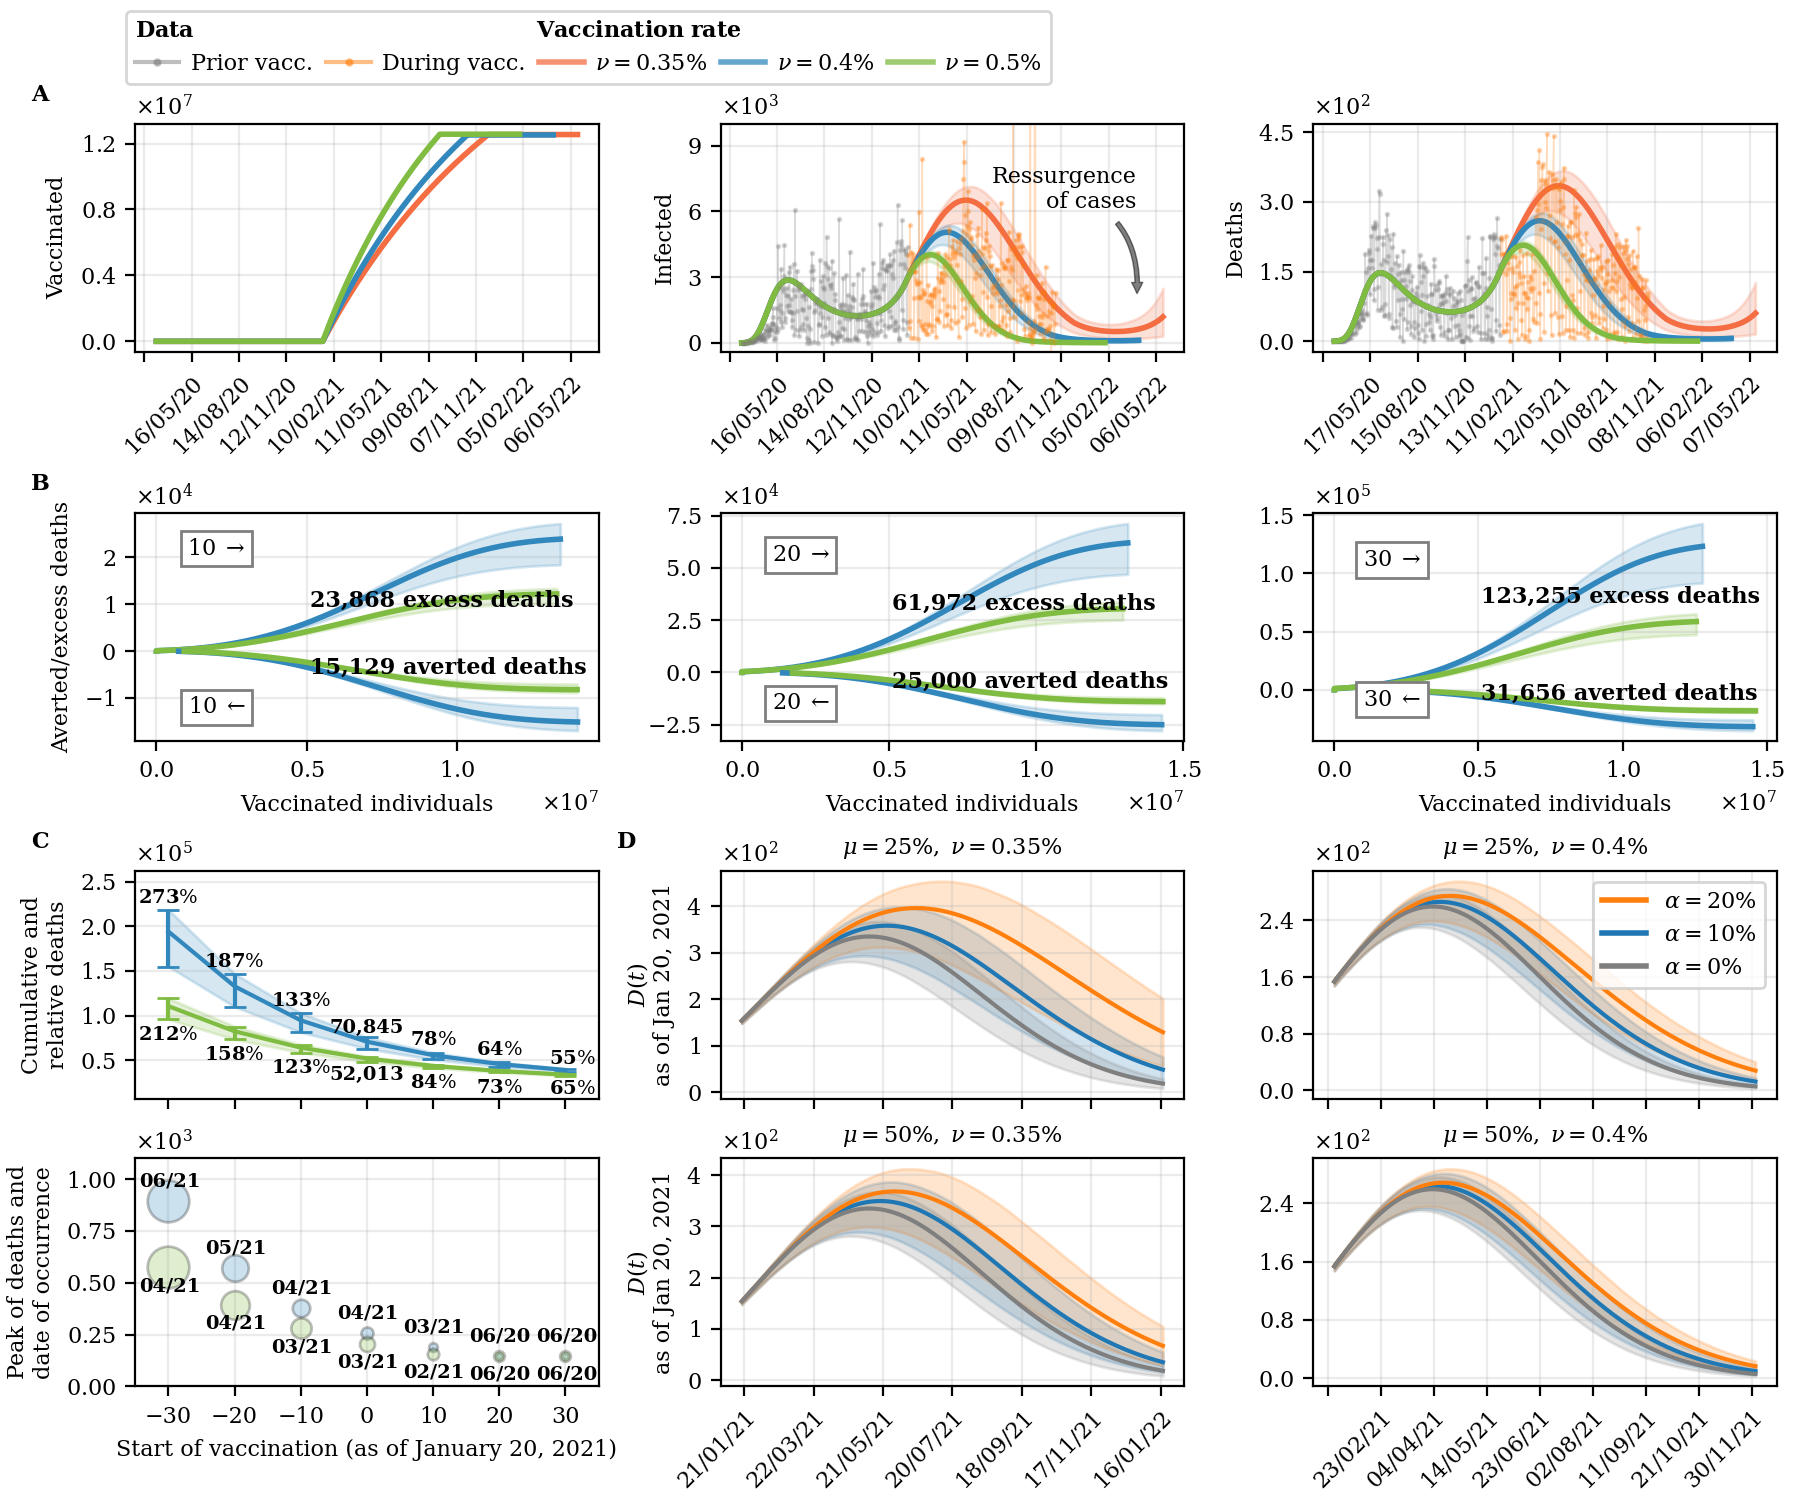



Figure 3a


-> Vaccination rate: 0.00350
--> QoI: W
--> QoI: I
---> 64.09% of the population would be immunised when 70% coverage had been reached with vaccination rate equal to 0.0.4.
---> Daily number of cases when 70% vaccination coverage is reached ussing the benchmark vaccination rate: 2171 (95% CI: 1280-2842)
---> Min daily infected after vaccination: 519 (95% CI: 206-856) on 18/02/22
---> Ressurgence: 1188 (95% CI: 313-2492) on 19/05/22
--> QoI: D

-> Vaccination rate: 0.00400
--> QoI: W
--> QoI: I
---> 70% vaccination coverage is reached on 08/10/21
---> Daily number of cases when 70% vaccination coverage is reached ussing the benchmark vaccination rate: 485 (95% CI: 290-629)
---> Min daily infected after vaccination: 99 (95% CI: 39-160) on 16/02/22
--> QoI: D

-> Vaccination rate: 0.00500
--> QoI: W
--> QoI: I
---> 72.78% of the population would be immunised when 70% coverage had been reached with vaccination rate equal to 0.0.4.
---> Daily number of cases when 70% vaccinati

--> Protection: 0.50
---> Without the second dose: 10%
188 days to reach 70% immunisations
Deaths on this day: 121 (95% CI: 86-143)
Cummulative deaths: 73814 (95% CI: 65126-79165)
---> Without the second dose: 20%
187 days to reach 70% immunisations
Deaths on this day: 143 (95% CI: 102-169)
Cummulative deaths: 77392 (95% CI: 67618-83575)
---> Without the second dose: 0%
190 days to reach 70% immunisations
Deaths on this day: 100 (95% CI: 71-118)
Cummulative deaths: 70846 (95% CI: 63037-75659)


In [89]:
ax3 = plt.figure(figsize=(9, 7.5), constrained_layout=True)
gs3 = ax3.add_gridspec(nrows=13, ncols=6)

ax_scenarios_limited_1 = ax3.add_subplot(gs3[1:4, 0:2])
ax_scenarios_limited_2 = ax3.add_subplot(gs3[1:4, 2:4])
ax_scenarios_limited_3 = ax3.add_subplot(gs3[1:4, 4:6])
ax_scenarios_limited = [ax_scenarios_limited_1, ax_scenarios_limited_2, ax_scenarios_limited_3]
plot_scenarios_limited(ax_scenarios_limited, vaccination_rate, model_sim_limited_doses, dates_before_vaccination,
                           dates_during_vaccination, data_before_vaccination, data_during_vaccination,
                           target_population, days_before_vaccination, fontsize)
ax_scenarios_limited_1.text(-0.225, 1.1, "A", transform=ax_scenarios_limited_1.transAxes, size=fontsize, weight="bold")

leg = plt.figlegend(handles = [plt.plot([],marker="o", linestyle='solid', color="C7", markersize=2, alpha=0.5)[0],
                         plt.plot([],marker="o", linestyle='solid', color="C1", markersize=2, alpha=0.5)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#f46d43", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#3288bd", alpha=0.75)[0],
                         plt.plot([],linestyle='solid', linewidth=2, color="#7fbc41", alpha=0.75)[0]],
                         labels=["Prior vacc.","During vacc.",r"$\nu=0.35\%$",r"$\nu=0.4\%$",r"$\nu=0.5\%$"],
                         title=r"$\mathrm{\bf{Data}\qquad\qquad\qquad\qquad\qquad\qquad\qquad\;\;\bf{Vaccination\;rate}}$",
                         ncol=5,handletextpad=0.5,columnspacing=0.625, bbox_to_anchor=(0.59, 1))
leg._legend_box.align = "left"

ax_scenarios_deaths_1 = ax3.add_subplot(gs3[4:7, 0:2])
ax_scenarios_deaths_2 = ax3.add_subplot(gs3[4:7, 2:4])
ax_scenarios_deaths_3 = ax3.add_subplot(gs3[4:7, 4:6])
ax_scenarios_deaths = (ax_scenarios_deaths_1, ax_scenarios_deaths_2, ax_scenarios_deaths_3)
plot_deaths_averted1(ax_scenarios_deaths, vaccination_rate, model_sim_scenario_analysis, days_before_vaccination)
ax_scenarios_deaths_1.text(-0.225, 1.1, "B", transform=ax_scenarios_deaths_1.transAxes, size=fontsize, weight="bold")

ax_deaths_averted = ax3.add_subplot(gs3[7:10, 0:2])
plot_deaths_averted2(ax_deaths_averted, vaccination_rate, model_sim_scenario_analysis, fontsize)

ax_deaths_averted2 = ax3.add_subplot(gs3[10:13, 0:2])
plot_deaths_peak(ax_deaths_averted2, vaccination_rate, model_sim_scenario_analysis, fontsize, days_before_vaccination, data_during_vaccination)
ax_deaths_averted.text(-0.225, 1.1, "C", transform=ax_deaths_averted.transAxes, size=fontsize, weight="bold")

ax_scenarios_second_1 = ax3.add_subplot(gs3[7:10, 2:4])
ax_scenarios_second_2 = ax3.add_subplot(gs3[7:10, 4:6])
ax_scenarios_second_3 = ax3.add_subplot(gs3[10:13, 2:4])
ax_scenarios_second_4 = ax3.add_subplot(gs3[10:13, 4:6])
ax_scenarios_second = [[ax_scenarios_second_1, ax_scenarios_second_2],
                       [ax_scenarios_second_3, ax_scenarios_second_4]]
plot_scenarios_second_D(ax_scenarios_second, vaccination_rate, model_sim_second_dose, dates_before_vaccination, target_population,
                        days_before_vaccination, fontsize)
ax_scenarios_second_1.text(-0.225, 1.1, "D", transform=ax_scenarios_second_1.transAxes, size=fontsize, weight="bold")


plt.savefig(f"{OUTPUT_PATH}/fig3.pdf")

## Plotting ICU beds occupancy

<IPython.core.display.Javascript object>


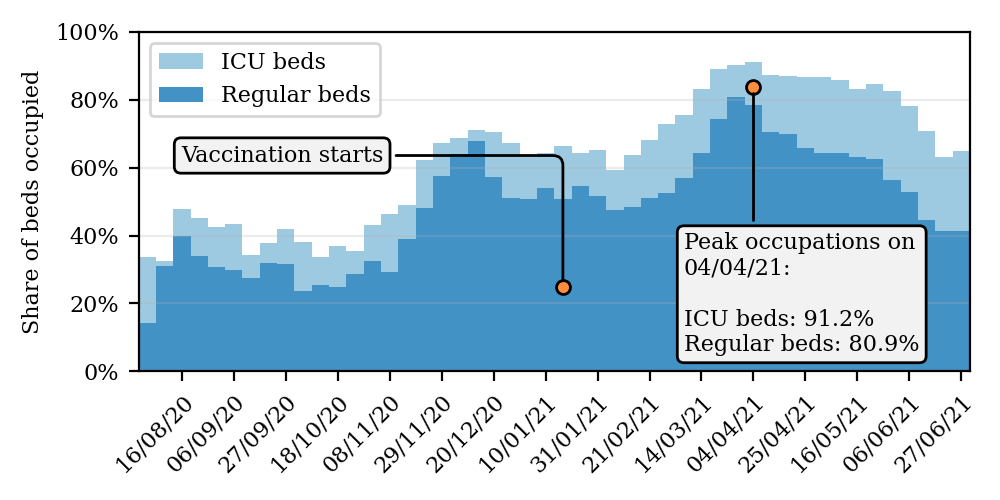

In [90]:
beds_epi_week = pd.read_excel(f"{INPUT_PATH}/regular_ICU_beds.xlsx").iloc[0:-7]
beds_epi_week = beds_epi_week.rename(columns={"Semana Epidemiológica": "week", "Enfermaria": "regular", "UTI": "ICU"})
weeks_dates = dict()
year_weeks = list()
regular_beds = list()
icu_beds = list()
epi_weeks = beds_epi_week["week"].values
for i, epi_week in enumerate(epi_weeks):
    n_week = str(int(epi_week[5:7]))
    date_week = epi_week[11:13] + "/" + epi_week[8:10] + "/" + epi_week[2:4]
    weeks_dates[date_week] = n_week
    year_weeks += [n_week + "/" + epi_week[2:4]]
    regular_beds += [beds_epi_week["regular"][i]]
    icu_beds += [beds_epi_week["ICU"][i]]
    
fig, ax = plt.subplots(figsize=(5.0, 2.5))

ax.bar(x=list(weeks_dates.keys()), height=icu_beds, width=1, color="#9ecae1", label="ICU beds")
ax.bar(x=list(weeks_dates.keys()), height=regular_beds, width=1, color="#4292c6", label="Regular beds")

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.legend(fontsize=fontsize)

ax.set_ylabel("Share of beds occupied")

ax.grid(axis="y", alpha=0.25)
  
bbox = dict(boxstyle ="round", fc ="0.95")
arrowprops = dict(
    arrowstyle = "-",
    connectionstyle = "angle, angleA = 0, angleB = 90,\
    rad = 10")
  
x_vacc, y_vacc = list(weeks_dates.keys()).index("17/01/21"), 0.25
ax.plot(x_vacc, y_vacc, "o", markersize=5, markerfacecolor="#fd8d3c", markeredgecolor="black")
offset = 50
  
ax.annotate("Vaccination starts",
            (x_vacc, y_vacc), xytext =(-2.75*offset, 0.9 * offset),
            textcoords ='offset points',
            bbox = bbox, arrowprops = arrowprops)

x_peak, y_peak = np.where(icu_beds == np.max(icu_beds))[0][0], np.max(icu_beds)-0.075
ax.plot(x_peak, y_peak, "o", markersize=5, markerfacecolor="#fd8d3c", markeredgecolor="black")

date_peak = list(weeks_dates.keys())[np.where(icu_beds == np.max(icu_beds))[0][0]]

ax.annotate(f"Peak occupations on\n{date_peak}:\n\nICU beds: {(np.max(icu_beds) * 100):.1f}%\nRegular beds: {(np.max(regular_beds) * 100):.1f}%",
            (x_peak, y_peak), xytext =(-0.5 * offset, -1.9 * offset),
            textcoords ='offset points',
            bbox = bbox, arrowprops = arrowprops)

ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])

ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

plt.savefig(f"{OUTPUT_PATH}/beds_occupied.pdf")

# Mobility

### Gathering data

In [91]:
MOBILITY_URL = "https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_brazil.csv"

raw_mobility_df = pd.read_csv(MOBILITY_URL, usecols=["sub region 1",
                                                 "sub region 2",
                                                 "date",
                                                 "retail and recreation",
                                                 "grocery and pharmacy",
                                                 "parks",
                                                 "transit stations",
                                                 "workplaces",
                                                 "residential"], parse_dates=["date"])
mobility_df = raw_mobility_df.loc[raw_mobility_df["sub region 1"] == "State of Rio de Janeiro"]
mobility_df = mobility_df.loc[mobility_df["sub region 2"] == "Total"]
mobility_df = mobility_df.reset_index(drop=True)

### Plotting data

<IPython.core.display.Javascript object>


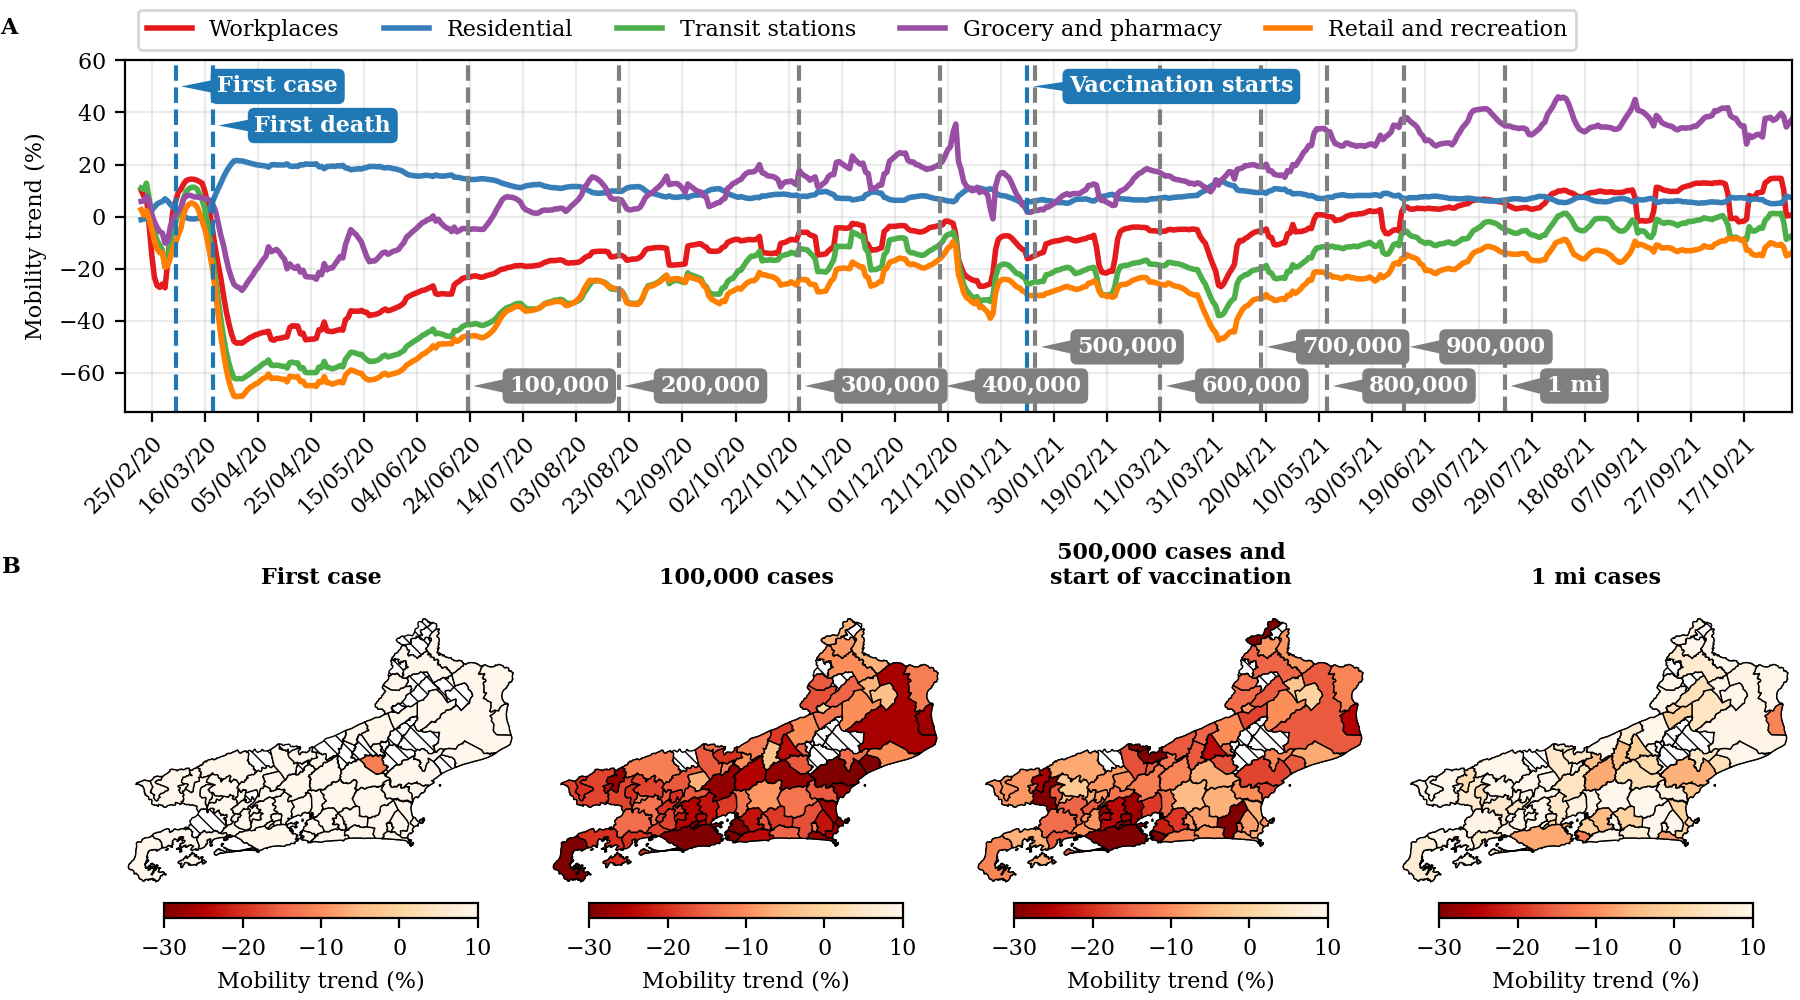

In [92]:
mobility_dates = mobility_df["date"]
mobility_dates = [date.strftime("%d/%m/%y") for date in mobility_dates]

mobility_workplaces = mobility_df["workplaces"]
mobility_residential = mobility_df["residential"]
mobility_transit_stations = mobility_df["transit stations"]
mobility_grocery_pharmacy = mobility_df["grocery and pharmacy"]
mobility_retail_recreation = mobility_df["retail and recreation"]

ax = plt.figure(figsize=(9, 5), constrained_layout=True)
gs = ax.add_gridspec(nrows=4, ncols=4)

ax_mobility = ax.add_subplot(gs[0:2, :])

p1, = ax_mobility.plot(mobility_dates, mobility_workplaces.rolling(window=7).mean(), label="Workplaces", color="#e41a1c", linewidth=2)
p2, = ax_mobility.plot(mobility_dates, mobility_residential.rolling(window=7).mean(), label="Residential", color="#377eb8", linewidth=2)
p3, = ax_mobility.plot(mobility_dates, mobility_transit_stations.rolling(window=7).mean(), label="Transit stations", color="#4daf4a", linewidth=2)
p4, = ax_mobility.plot(mobility_dates, mobility_grocery_pharmacy.rolling(window=7).mean(), label="Grocery and pharmacy", color="#984ea3", linewidth=2)
p5, = ax_mobility.plot(mobility_dates, mobility_retail_recreation.rolling(window=7).mean(), label="Retail and recreation", color="#ff7f00", linewidth=2)

plt.legend(handles=[p1, p2, p3, p4, p5], fontsize=fontsize, ncol=5, bbox_to_anchor=(0.8775,1.175))

ax_mobility.set_xlim([mobility_dates[0], mobility_dates[-1]])
ax_mobility.set_ylabel("Mobility trend (%)", fontsize=fontsize)

ax_mobility.xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.setp(ax_mobility.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax_mobility.yaxis.set_ticks([-60, -40, -20, 0, 20, 40, 60])
ax_mobility.set_yticklabels([r"$-60$", r"$-40$", r"$-20$", r"$0$", r"$20$", r"$40$", r"$60$"])

ax_mobility.grid(alpha=0.25)

from matplotlib.patches import Ellipse
el = Ellipse((2, -1), 0.5, 0.5)

day_1k_cases = np.where(np.cumsum(infected_individuals) >= 100_000)[0][0] + 24
day_2k_cases = np.where(np.cumsum(infected_individuals) >= 200_000)[0][0] + 24
day_3k_cases = np.where(np.cumsum(infected_individuals) >= 300_000)[0][0] + 24
day_4k_cases = np.where(np.cumsum(infected_individuals) >= 400_000)[0][0] + 24
day_5k_cases = np.where(np.cumsum(infected_individuals) >= 500_000)[0][0] + 24
day_6k_cases = np.where(np.cumsum(infected_individuals) >= 600_000)[0][0] + 24
day_7k_cases = np.where(np.cumsum(infected_individuals) >= 700_000)[0][0] + 24
day_8k_cases = np.where(np.cumsum(infected_individuals) >= 800_000)[0][0] + 24
day_9k_cases = np.where(np.cumsum(infected_individuals) >= 900_000)[0][0] + 24
day_10k_cases = mobility_dates.index("19/07/21")

save_ylim = ax_mobility.get_ylim()
ax_mobility.plot(np.repeat(day_1k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_2k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_3k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_4k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_5k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_6k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_7k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_8k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_9k_cases, 2), list(save_ylim), "--", color="C7")
ax_mobility.plot(np.repeat(day_10k_cases, 2), list(save_ylim), "--", color="C7")

ax_mobility.set_ylim(save_ylim)

def annotation_facts(str_cases, day_cases, y_pos, box_color):
    ax_mobility.annotate(str_cases,
                xy=(day_cases, y_pos), xycoords='data', weight='bold', color='white',
                xytext=(15, 0), textcoords='offset points',
                size=fontsize, va="center",
                bbox=dict(boxstyle="round", fc=box_color, ec="none"),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                fc=box_color, ec="none",
                                patchA=None,
                                patchB=el,
                                relpos=(0.2, 0.5)))

annotation_facts("100,000", day_1k_cases, -65, "C7")
annotation_facts("200,000", day_2k_cases, -65, "C7")
annotation_facts("300,000", day_3k_cases, -65, "C7")
annotation_facts("400,000", day_4k_cases, -65, "C7")
annotation_facts("500,000", day_5k_cases, -50, "C7")
annotation_facts("600,000", day_6k_cases, -65, "C7")
annotation_facts("700,000", day_7k_cases, -50, "C7")
annotation_facts("800,000", day_8k_cases, -65, "C7")
annotation_facts("900,000", day_9k_cases, -50, "C7")
annotation_facts("1 mi", day_10k_cases, -65, "C7")

day_first_case = mobility_dates.index("05/03/20")
day_first_death = mobility_dates.index("19/03/20")
day_vaccination_starts = mobility_dates.index("20/01/21")

annotation_facts("First case", day_first_case, 50, "C0")
annotation_facts("First death", day_first_death, 35, "C0")
annotation_facts("Vaccination starts", day_vaccination_starts, 50, "C0")

ax_mobility.plot(np.repeat(day_first_case, 2), list(save_ylim), "--", color="C0")
ax_mobility.plot(np.repeat(day_first_death, 2), list(save_ylim), "--", color="C0")
ax_mobility.plot(np.repeat(day_vaccination_starts, 2), list(save_ylim), "--", color="C0")

ax_mobility.text(-0.075, 1.075, "A", transform=ax_mobility.transAxes, size=fontsize, weight="bold")

############################ MAPS ############################

INFOS_MUNICIPALITIES = gpd.read_file(f"{INPUT_PATH}/bcim_2016_21_11_2018.gpkg", layer="lim_municipio_a")
NAMES_MUNICIPALITIES = ["Angra dos Reis", "Aperibé", "Araruama", "Areal", "Armação dos Búzios",
                        "Arraial do Cabo", "Barra do Piraí", "Barra Mansa", "Belford Roxo",
                        "Bom Jardim", "Bom Jesus do Itabapoana", "Cabo Frio", "Cachoeiras de Macacu",
                        "Cambuci", "Campos dos Goytacazes", "Cantagalo", "Carapebus", "Cardoso Moreira",
                        "Carmo", "Casimiro de Abreu", "Comendador Levy Gasparian", "Conceição de Macabu",
                        "Cordeiro", "Duas Barras", "Duque de Caxias", "Engenheiro Paulo de Frontin",
                        "Guapimirim", "Iguaba Grande", "Itaboraí", "Itaguaí", "Italva", "Itaocara",
                        "Itaperuna", "Itatiaia", "Japeri", "Laje do Muriaé", "Macaé", "Macuco", "Magé",
                        "Mangaratiba", "Maricá", "Mendes", "Mesquita", "Miguel Pereira", "Miracema",
                        "Natividade", "Nilópolis", "Niterói", "Nova Friburgo", "Nova Iguaçu", "Paracambi",
                        "Paraíba do Sul", "Paraty", "Paty do Alferes", "Petrópolis", "Pinheiral", "Piraí",
                        "Porciúncula", "Porto Real", "Quatis", "Queimados", "Quissamã", "Resende",
                        "Rio Bonito", "Rio Claro", "Rio das Flores", "Rio das Ostras", "Rio de Janeiro",
                        "Santa Maria Madalena", "Santo Antônio de Pádua", "São Fidélis",
                        "São Francisco de Itabapoana", "São Gonçalo", "São João da Barra",
                        "São João de Meriti", "São José de Ubá", "São José do Vale do Rio Preto",
                        "São Pedro da Aldeia", "São Sebastião do Alto", "Sapucaia", "Saquarema",
                        "Seropédica", "Silva Jardim", "Sumidouro", "Tanguá", "Teresópolis",
                        "Trajano de Moraes", "Três Rios", "Valença", "Varre-Sai", "Vassouras", "Volta Redonda"]
DATES_TO_PLOT = ["2020-03-05", "2020-06-23", "2021-01-20", "2021-07-19"]
EVENTS_TO_PLOT = ["First case", "100,000 cases", "500,000 cases and\nstart of vaccination", "1 mi cases"]
PLACES_TO_PLOT = ["workplaces"]
INFOS_MUNICIPALITIES_RJ = INFOS_MUNICIPALITIES.loc[INFOS_MUNICIPALITIES["nome"].isin(NAMES_MUNICIPALITIES)]

mobility_df_RJ = raw_mobility_df.loc[raw_mobility_df["sub region 1"] == "State of Rio de Janeiro"]

matplotlib.rcParams['hatch.linewidth'] = 0.5

for i, place in enumerate(PLACES_TO_PLOT):
    cmap = "OrRd_r" if place == "workplaces" else "PuBu_r"
    for j, date in enumerate(DATES_TO_PLOT):
        ax_mobility_map = ax.add_subplot(gs[2:4, j])
        INFOS_MUNICIPALITIES_RJ.plot(color='white',
                                     hatch='\\\\\\\\',
                                     edgecolor="black",
                                     linewidth=0.5,
                                     ax=ax_mobility_map)
        
        municipality_place = list()
        INFOS_MUNICIPALITIES_RJ_PLACES = INFOS_MUNICIPALITIES_RJ
        for name in NAMES_MUNICIPALITIES:
            mobility_municipality = mobility_df_RJ.loc[mobility_df_RJ["sub region 2"] == name]
            mobility_municipality_place = mobility_municipality.loc[mobility_df_RJ["date"] == date][place].values
            if mobility_municipality_place.size == 1:
                municipality_place.append(mobility_municipality_place[0])
            else:
                municipality_place.append(np.NaN)

        INFOS_MUNICIPALITIES_RJ_PLACES = INFOS_MUNICIPALITIES_RJ_PLACES.merge(
            pd.DataFrame(data={"nome": NAMES_MUNICIPALITIES, place: municipality_place}),
            on="nome", how="left")
        
        INFOS_MUNICIPALITIES_RJ_PLACES.plot(column=place,
                                            cmap=cmap,
                                            edgecolor="black",
                                            linewidth=0.5,
                                            vmin=-30,
                                            vmax=10,
                                            ax=ax_mobility_map,
                                            legend=True,
                                            legend_kwds={"label": "Mobility trend (%)",
                                                         "location": "bottom",
                                                         "shrink": 0.8,
                                                         "aspect": 20})
        if i == 0:
            ax_mobility_map.set_title(EVENTS_TO_PLOT[j], y=1.05, fontsize=fontsize, weight="bold")
            if j == 0:
                ax_mobility_map.text(-0.315, 1.15, "B", transform=ax_mobility_map.transAxes, size=fontsize, weight="bold")
        
        ax_mobility_map.set_xlim([-44.92, -40.92])
        ax_mobility_map.set_ylim([-23.4, -20.72])

        ax_mobility_map.axis("off")
        
temp = INFOS_MUNICIPALITIES_RJ

plt.savefig(f"{OUTPUT_PATH}/" + "mobility.pdf")